# Board Game Geek Data Project

In [143]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_union, make_pipeline, FeatureUnion, Pipeline
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier, \
    GradientBoostingClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, silhouette_score, r2_score, accuracy_score
from sklearn.cluster import KMeans, DBSCAN
import requests
import xmltodict
import time
import regex as re
import math
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

# EDA/Preprocessing

In [2]:
df = pd.read_csv('datasets/bgg_db_2017_04.csv',encoding='cp1250')
df.head(3) 

rank                                            bgg_url  game_id  \
0     1  https://boardgamegeek.com/boardgame/161936/pan...   161936   
1     2  https://boardgamegeek.com/boardgame/182028/thr...   182028   
2     3  https://boardgamegeek.com/boardgame/12333/twil...    12333   

                                           names  min_players  max_players  \
0                      Pandemic Legacy: Season 1            2            4   
1  Through the Ages: A New Story of Civilization            2            4   
2                              Twilight Struggle            2            2   

   avg_time  min_time  max_time  year  avg_rating  geek_rating  num_votes  \
0        60        60        60  2015     8.66905      8.48904      18009   
1       240       180       240  2015     8.72977      8.30744       7309   
2       180       180       180  2005     8.35745      8.22021      27403   

                                           image_url  age  \
0  https://cf.geekdo-images.com/images/pic2452831...   13   
1  https://cf.geekdo-images.com/images/pic2663291...   14   
2  https://cf.geekdo-images.com/images/pic361592.jpg   13   

                                            mechanic  owned  \
0  Action Point Allowance System, Co-operative Pl...  29472   
1  Action Point Allowance System, Auction/Bidding...  10007   
2  Area Control / Area Influence, Campaign / Batt...  37382   

                             category                      designer  weight  
0              Environmental, Medical      Rob Daviau, Matt Leacock  2.8076  
1   Card Game, Civilization, Economic                Vlaada Chvátil  4.3093  
2  Modern Warfare, Political, Wargame  Ananda Gupta, Jason Matthews  3.5317

In [3]:
#drop columns that only contain unique values for each game
df.drop(['bgg_url','game_id','image_url'],axis=1,inplace=True)
#drop rank as it's just a proxy for geek_rating
df.drop('rank',axis=1,inplace=True)
#drop columns that new games won't have
df.drop(['num_votes','owned'],axis=1,inplace=True)
df.head(3)

names  min_players  max_players  \
0                      Pandemic Legacy: Season 1            2            4   
1  Through the Ages: A New Story of Civilization            2            4   
2                              Twilight Struggle            2            2   

   avg_time  min_time  max_time  year  avg_rating  geek_rating  age  \
0        60        60        60  2015     8.66905      8.48904   13   
1       240       180       240  2015     8.72977      8.30744   14   
2       180       180       180  2005     8.35745      8.22021   13   

                                            mechanic  \
0  Action Point Allowance System, Co-operative Pl...   
1  Action Point Allowance System, Auction/Bidding...   
2  Area Control / Area Influence, Campaign / Batt...   

                             category                      designer  weight  
0              Environmental, Medical      Rob Daviau, Matt Leacock  2.8076  
1   Card Game, Civilization, Economic                Vlaada Chvátil  4.3093  
2  Modern Warfare, Political, Wargame  Ananda Gupta, Jason Matthews  3.5317

In [5]:
df.shape

(4999, 14)

In [4]:
df.isnull().sum()

names          0
min_players    0
max_players    0
avg_time       0
min_time       0
max_time       0
year           0
avg_rating     0
geek_rating    0
age            0
mechanic       0
category       0
designer       0
weight         0
dtype: int64

In [4]:
df['name_len'] = df.names.map(lambda x: len(x))

In [6]:
df.dtypes

names           object
min_players      int64
max_players      int64
avg_time         int64
min_time         int64
max_time         int64
year             int64
avg_rating     float64
geek_rating    float64
age              int64
mechanic        object
category        object
designer        object
weight         float64
name_len         int64
dtype: object

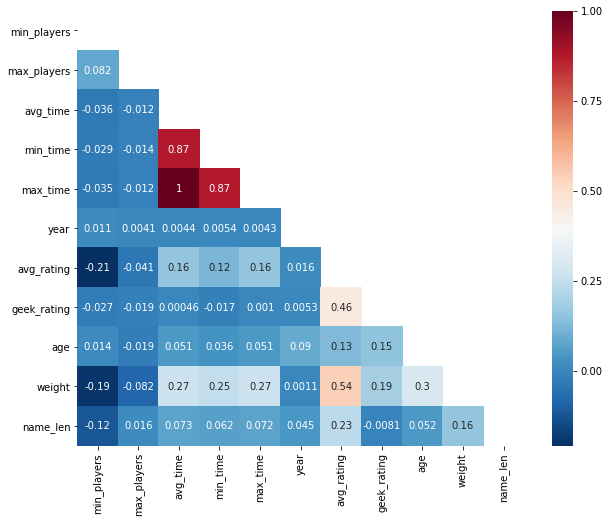

In [10]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,8))
sns.heatmap(corr,mask=mask,annot=True,cmap='RdBu_r')

In [5]:
#drop highly colinear features
df.drop(['min_time','max_time'],axis=1,inplace=True)

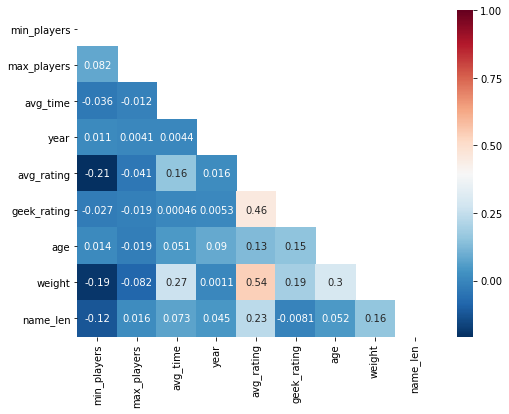

In [12]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8,6))
sns.heatmap(corr,mask=mask,annot=True,cmap='RdBu_r')

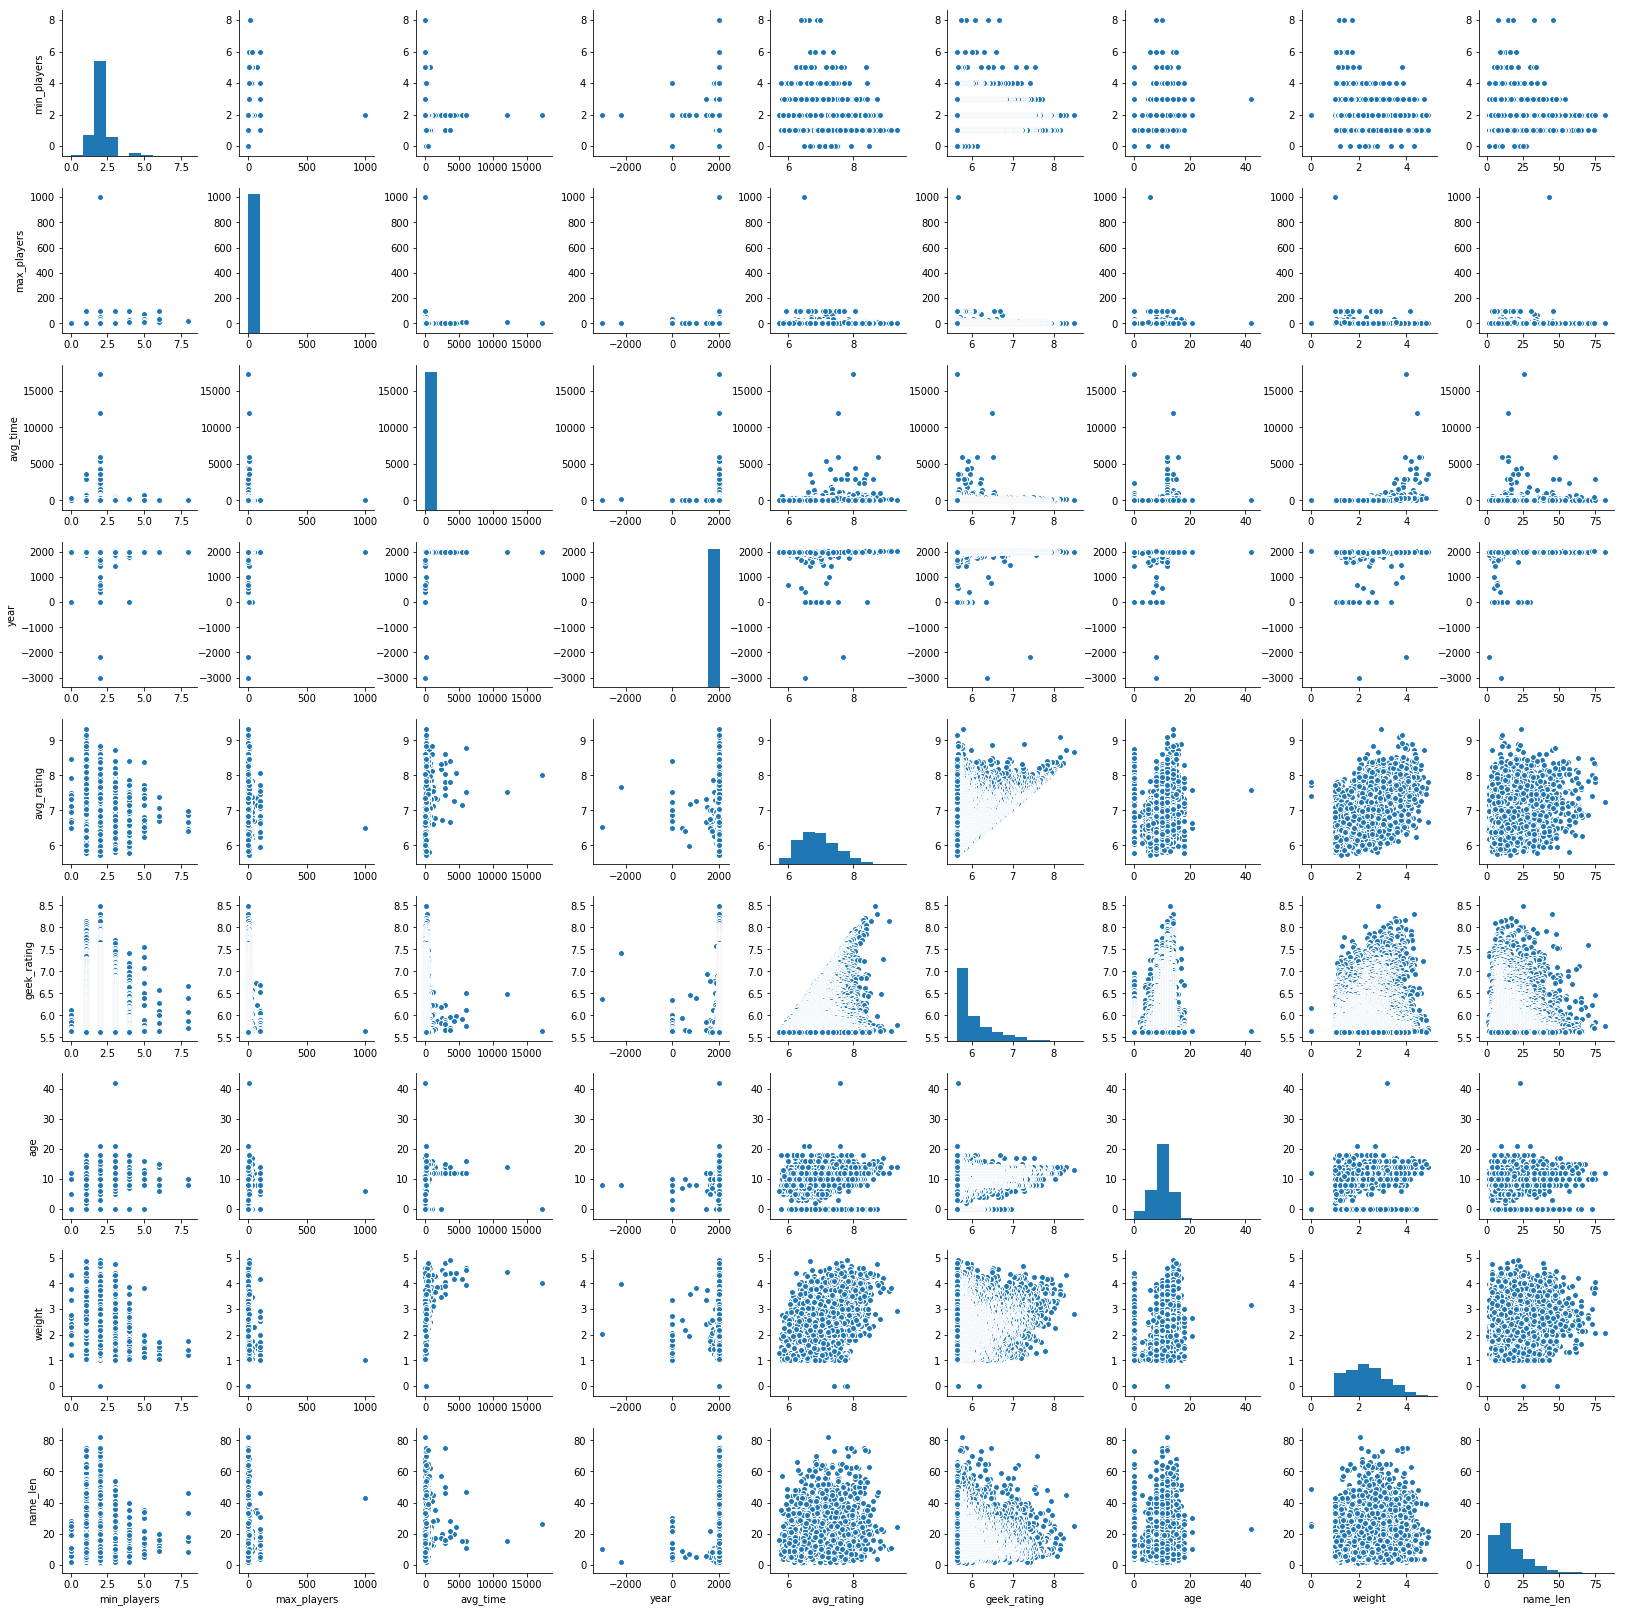

In [27]:
sns.pairplot(df)

In [6]:
#Create year cuttoff of 1950 and mark gams released before 1900 as 'classic'
df['Classic'] = df.year.map(lambda x: 1 if x < 1900 else 0)
df.year = df.year.map(lambda x: 1950 if x < 1950 else x)

In [11]:
df.max_players.value_counts().sort_index()

0        26
1        77
2      1012
3        68
4      1580
5       897
6       797
7        94
8       238
9        16
10       71
11        2
12       42
13        1
15        9
16       10
18        8
20        9
21        2
24        3
30        6
33        2
34        1
52        1
68        1
75        1
99       23
100       1
999       1
Name: max_players, dtype: int64

In [7]:
#Set cap on max_players of 20
df.max_players = df.max_players.map(lambda x: min(x,20))

In [13]:
df.avg_time.value_counts().sort_index()

0         82
1          2
2          2
5         20
10        95
12         1
13         2
15       200
19         1
20       328
25        49
30       786
32         1
35        15
40       100
42         1
45       597
50        25
55         3
60       817
70        14
75        70
80         9
90       504
95         1
100       22
105        1
110        1
115        1
120      481
        ... 
270        1
290        1
300       56
360      114
420        4
480       22
500        1
540        1
600        6
700        1
720        6
750        1
900        2
960        3
1000       2
1200       4
1440       1
1500       1
1800       1
2400       2
2480       1
2880       2
3000       4
3600       3
4320       1
4500       1
5400       1
6000       3
12000      1
17280      1
Name: avg_time, Length: 69, dtype: int64

(0.0, 50)

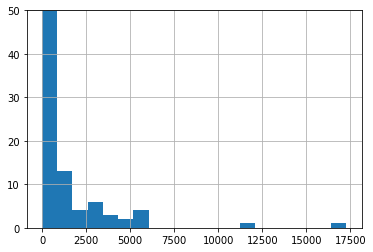

In [14]:
df.avg_time.hist(bins=20)
plt.ylim(ymax=50)

In [8]:
#Enforce a cutoff for the avg_time of 8 hours (480 min)
df.avg_time = df.avg_time.map(lambda x: min(x,480))

In [16]:
df.age.value_counts().sort_index()

0      252
2        1
3        8
4       23
5       46
6      100
7       90
8      807
9       82
10    1106
11      33
12    1459
13     435
14     447
15      45
16      32
17       9
18      20
21       3
42       1
Name: age, dtype: int64

In [9]:
#Set suggested minimum age to have a cutoff of 21 years old
df.age = df.age.map(lambda x: min(x,21))

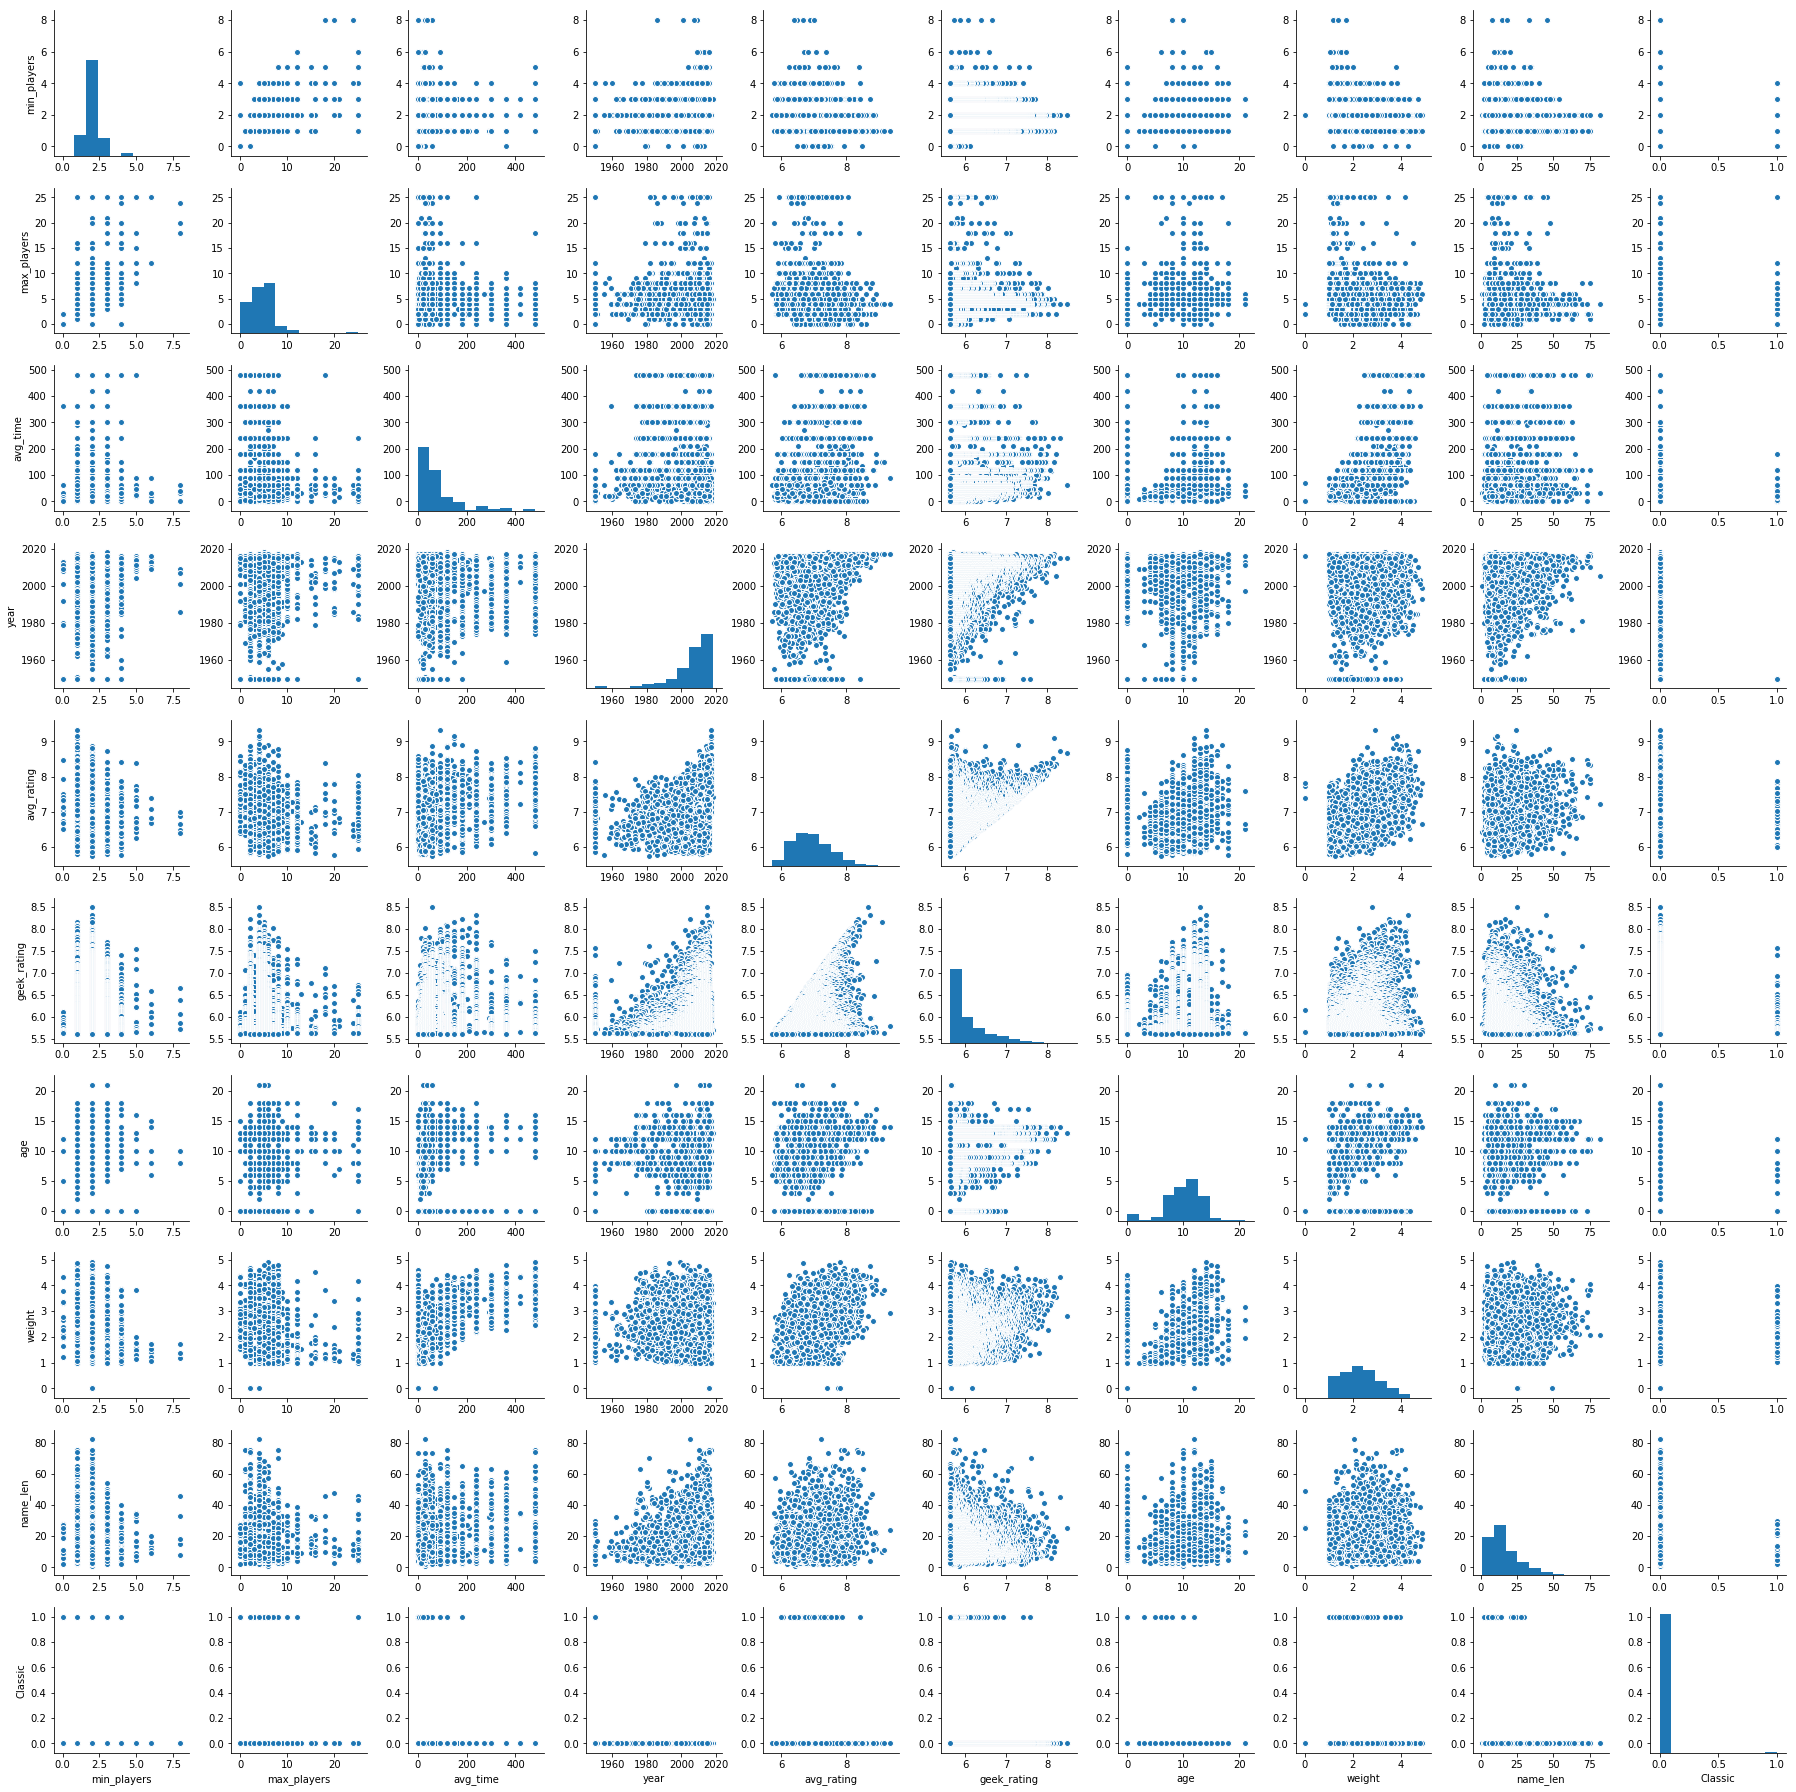

In [37]:
sns.pairplot(df)

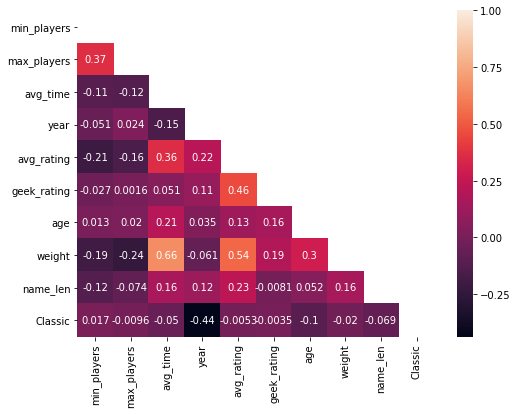

In [21]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8,6))
sns.heatmap(corr,mask=mask,annot=True)

The strongest features that correlate with geek_rating apepar to be weight, age, and year. There are no colinear features (coefficient > 0.8)

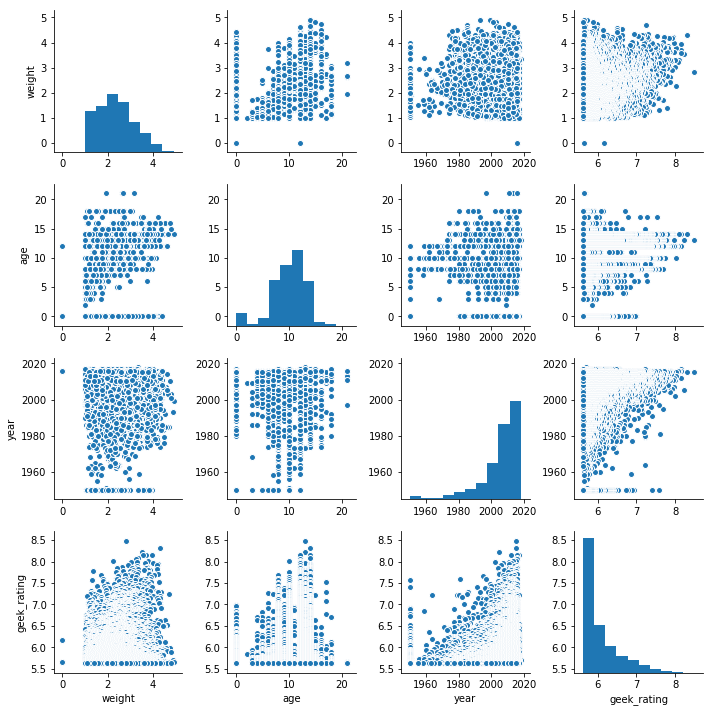

In [40]:
sns.pairplot(df[['weight','age','year','geek_rating']])

In [18]:
df.groupby('name_len').count().geek_rating

name_len
1       1
2      10
3      36
4     100
5     160
6     241
7     243
8     292
9     296
10    305
11    270
12    235
13    254
14    227
15    203
16    157
17    153
18    142
19    144
20    128
21     90
22     94
23    107
24     82
25     80
26     64
27     84
28     66
29     65
30     57
     ... 
43     19
44     14
45     13
46     14
47     15
48     11
49     17
50      9
51      8
52      6
53      3
54      4
55      5
56      6
57      5
58      1
59      4
60      1
61      4
62      5
63      5
64      3
65      4
66      2
68      1
70      2
73      3
74      1
75      3
82      1
Name: geek_rating, Length: 72, dtype: int64

In [19]:
s = df.groupby('name_len').count().geek_rating
my_pal = {}
for key in s.index:
    my_pal[key] = s[key]

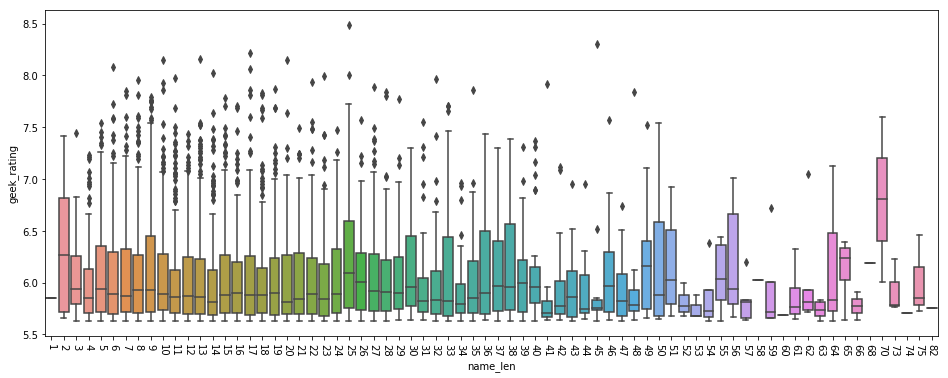

In [20]:
plt.figure(figsize=(16,6))
sns.boxplot('name_len','geek_rating',data=df)#,color=df.groupby('name_len').count()['names'].values)
plt.xticks(rotation=270)
# plt.colorbar()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E3D5EA3BA8>]], dtype=object)

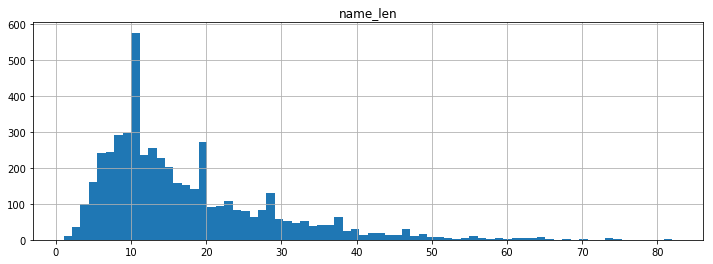

In [21]:
df.hist('name_len',bins=72,figsize=(12,4),)

In [10]:
#Change games with 'none' for designer to '(Uncredited)
df.loc[(df.designer=='none') | (df.designer=='(Uncredited)'),'designer'] = 'Designer Unknown'
df.loc[df.mechanic=='none','mechanic'] = 'Mechanic Unknown'
df.loc[df.category=='none','category'] = 'Category Unknown'

In [13]:
df.groupby('designer').count().age.sort_values(ascending=False).shape

(2471,)

In [192]:
X = df.drop(['geek_rating','avg_rating'],axis=1)
y = df.geek_rating
X_use, X_hold, y_use, y_hold = train_test_split(X,y,test_size=.3)
X_train, X_test, y_train, y_test = train_test_split(X_use,y_use,test_size=.3)

In [11]:
def cleaning(text):
    text = text.replace(', Jr.',' Jr.').split(',')
    text = [word.strip() for word in text]
    return text
#Setting min_df (document frequency) means that designers that have designed fewer than min_df games won't show up
#in the bag of words
# cvec = CountVectorizer(analyzer=cleaning,min_df=7) 
# dummies = pd.DataFrame(cvec.fit_transform(X_train.designer).todense(),columns=cvec.get_feature_names())
# dummies.head()

In [12]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    """Select out one or more features and returns them in the shape (n_rows,n_features)"""
    def __init__(self, column):
        self.column = column 
        
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        if type(self.column) == list:
            return X[self.column].values 
        else:
            return X[[self.column]].values 
        

class RowFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select out one feature and return it in the shape (n_rows,)"""
    def __init__(self, column):
        self.column = column 
        
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        return X[self.column].values 

#Extract and count vecotrize the categorical columns, analgous to get_dummies since
#each 'document' can only have a given token once
    
#create pipeline for game mechanic feature
mechanic_pipe = make_pipeline(
    RowFeatureExtractor('mechanic'),
    CountVectorizer(analyzer=cleaning)
)

#create pipeline for game category feature
category_pipe = make_pipeline(
    RowFeatureExtractor('category'),
    CountVectorizer(analyzer=cleaning)
)

#create pipeline for game designer feature
designer_pipe = make_pipeline(
    RowFeatureExtractor('designer'),
    CountVectorizer(analyzer=cleaning, min_df=7), #min_df culls designers that don't have at least that many games
)

#define sigma clipping function for the numeric columns
def sigma_clip(df,n_low=3,n_high=3):
    """
    Performs sigma clipping on the numeric columns of DataFrame df.
    Columns used are name_len, min_players, max_players, avg_time, year, age, and weight.
    n_lower and n_upper set how many sigmas below or above the mean, respectively, you want to clip
    """
    
    df = pd.DataFrame(df)
    n_low = 3
    n_high = 3
    for col in df.columns:
        mean = df[col].mean()
        std = df[col].std()
        df.loc[df[col]<mean-n_low*std,col] = mean - n_low*std
        df.loc[df[col]>mean+n_high*std,col] = mean + n_high*std
    return df.values

#convert sigma-clipping function into a sklarn transformer
SigmaClipTF = FunctionTransformer(sigma_clip,validate=False)

#create pipeline for numerical features
numerical_pipe = make_pipeline(
    FeatureExtractor(['name_len','min_players','max_players','avg_time',
                      'year','age','weight']),
    SigmaClipTF,
    MinMaxScaler()
)

#combine outputs of various pipes as well as the 'Classical' column
fu = FeatureUnion([
    ('num_pipe',numerical_pipe),
    ('Classic',FeatureExtractor('Classic')),
    ('mech_pipe',mechanic_pipe),
    ('cat_pipe',category_pipe),
    ('des_pipe',designer_pipe)
])

In [71]:
#Calculate SVD using the maximum number of components
X_temp = fu.fit_transform(X_train)
svd = TruncatedSVD(X_temp.shape[1]-1)
svd.fit(X_temp)

TruncatedSVD(algorithm='randomized', n_components=246, n_iter=5,
       random_state=None, tol=0.0)

In [87]:
X_temp.shape

(3199, 247)

Text(0,0.5,'Fraction of Total Variance Explaned')

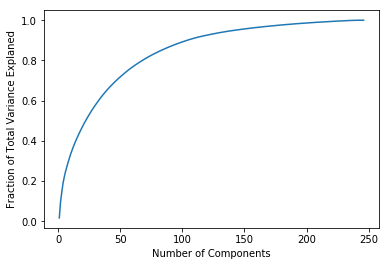

In [72]:
#Plot explained variance versus number of components
components = np.arange(1,X_temp.shape[1])
var = svd.explained_variance_ratio_.cumsum()
plt.plot(components,var)
plt.xlabel('Number of Components')
plt.ylabel('Fraction of Total Variance Explaned')

In [152]:
#Establish a baseline score (rmse) using the mean geek_ratig as a prediction for all games
print('Baseline RMSE (train):',mean_squared_error(y_train,[y_train.mean() for _ in y_train])**.5)
print('Baseline RMSE (test):',mean_squared_error(y_test,[y_test.mean() for _ in y_test])**.5) 

Baseline RMSE (train): 0.481788143075
Baseline RMSE (test): 0.462590425541


In [74]:
#This cell can be used to analyze the effect of changing min_df while holding everything else constant.
#It also lists the features in order of decreasing feature importance

#pipeline just does feature transformations and random forest model
pipe = Pipeline([
    ('fu',fu),
    ('rm',RandomForestRegressor(n_estimators=20,max_depth=10,max_features='sqrt'))
])

#set values of min_df to search over
grid = {
    'fu__des_pipe__countvectorizer__min_df': [1,3,5,7,9,12,15] 
}

gs = GridSearchCV(pipe,grid,scoring='neg_mean_squared_error',\
                  return_train_score=True)
gs.fit(X_train,y_train)

#print the RMSE scores for the train and the test set using the best mdoel
print('Train score:',abs(gs.score(X_train,y_train))**.5)
print('Test score:',abs(gs.score(X_test,y_test))**.5)

#Print the best params found during grid search
print(gs.best_params_)

#For each min_df in the grid, print the mean train/test scores found during CV as well as their diff
for n,train_score,test_score in zip(gs.cv_results_['params'],gs.cv_results_['mean_train_score'],gs.cv_results_['mean_test_score']):
    min_df = n['fu__des_pipe__countvectorizer__min_df']
    train_score = abs(train_score)**.5
    test_score = abs(test_score)**.5
    print('min_df:',min_df,'train score:',train_score,'test score:',test_score,'diff:',test_score-train_score)

#create list of features including numerical columns and count-vectorized categorical columns
columns = ['name_len','min_players','max_players','avg_time','year','age','weight','Classic'] +\
    gs.best_estimator_.named_steps['fu'].transformer_list[2][1].named_steps['countvectorizer'].get_feature_names()+\
    gs.best_estimator_.named_steps['fu'].transformer_list[3][1].named_steps['countvectorizer'].get_feature_names()+\
    gs.best_estimator_.named_steps['fu'].transformer_list[4][1].named_steps['countvectorizer'].get_feature_names()

#get feature importances from the best fitted model and construct a df 
feature_weights = pd.DataFrame({'Feature Weight': gs.best_estimator_.named_steps['rm'].feature_importances_,
        'Feature': columns})

#sort the df by feature importance
feature_weights.sort_values('Feature Weight',ascending=False)

Train score: 0.373639651865
Test score: 0.434778824546
{'fu__des_pipe__countvectorizer__min_df': 12}
min_df: 1 train score: 0.413029023715 test score: 0.447069436205 diff: 0.0340404124905
min_df: 3 train score: 0.376507090885 test score: 0.438067449403 diff: 0.0615603585185
min_df: 5 train score: 0.364747080126 test score: 0.433315576403 diff: 0.0685684962771
min_df: 7 train score: 0.361626323564 test score: 0.431943582517 diff: 0.0703172589532
min_df: 9 train score: 0.359467368834 test score: 0.433433451669 diff: 0.0739660828347
min_df: 12 train score: 0.353991741166 test score: 0.429956259337 diff: 0.0759645181707
min_df: 15 train score: 0.349738633855 test score: 0.43104052414 diff: 0.0813018902854


Feature  Feature Weight
6                           weight    9.219869e-02
3                         avg_time    6.147961e-02
5                              age    4.698502e-02
4                             year    4.350998e-02
84                        Economic    3.766419e-02
0                         name_len    3.587075e-02
57          Variable Player Powers    3.023136e-02
59                Worker Placement    2.787295e-02
11   Area Control / Area Influence    2.614256e-02
18                   Card Drafting    2.134368e-02
2                      max_players    2.105383e-02
26                 Hand Management    2.030301e-02
27                 Hex-and-Counter    1.888467e-02
149                Corey Konieczka    1.841847e-02
56            Variable Phase Order    1.517571e-02
1                      min_players    1.396987e-02
92                        Fighting    1.318524e-02
25                   Grid Movement    1.191107e-02
185                 Vlaada Chvátil    1.164966e-02
91                         Farming    1.129402e-02
31                   Modular Board    1.066731e-02
96        Industry / Manufacturing    1.044424e-02
128                Science Fiction    9.570531e-03
45                  Set Collection    9.354276e-03
181                    Stefan Feld    8.845127e-03
184                  Uwe Rosenberg    7.926734e-03
103                       Medieval    7.909734e-03
52                  Tile Placement    7.763157e-03
77                   City Building    7.739459e-03
15                 Auction/Bidding    7.423853e-03
..                             ...             ...
159                 Jervis Johnson    2.227534e-04
55                    Trick-taking    1.986693e-04
150             D. Brad Talton Jr.    1.794718e-04
99                            Math    1.780581e-04
104                         Memory    1.720519e-04
8                           Acting    1.692380e-04
169               Michael Kiesling    1.638285e-04
63                   Age of Reason    1.564137e-04
138                    Vietnam War    1.526561e-04
157                 Frédéric Henry    1.497263e-04
101                           Maze    1.476736e-04
164                   Leo Colovini    7.646648e-05
161                   Kevin Wilson    7.586472e-05
154                      Dirk Henn    7.389541e-05
168                      Matt Hyra    7.196512e-05
117                  Pike and Shot    7.063008e-05
40             Rock-Paper-Scissors    6.513650e-05
177                 Rick Priestley    5.548723e-05
109                          Music    3.496268e-05
160             Joseph M. Balkoski    1.979843e-05
152                     Dean Essig    1.827183e-05
88         Expansion for Base-game    1.633134e-05
22              Crayon Rail System    1.533398e-05
182              Steve Jackson (I)    1.532274e-05
115                         Number    1.151758e-05
145                  Andrew Looney    6.330076e-06
93                     Game System    3.992701e-06
97                      Korean War    3.305100e-07
48                         Singing    0.000000e+00
172                   Mike Elliott    0.000000e+00

[187 rows x 2 columns]

In [23]:
pipe = Pipeline([
    ('fu', fu),
    ('gs', GridSearchCV(RandomForestRegressor(),
            param_grid={'min_samples_leaf': [1,3,5,7],
                       'max_features': [None,1/3],
                       'n_estimators': np.arange(25,151,25)},
            scoring='neg_mean_squared_error',
            verbose=2,
            return_train_score=True))
])

In [24]:
pipe.fit(X_train,y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0.01 ...................
[CV] .... alpha=0.01, fit_intercept=True, l1_ratio=0.01, total=   0.0s
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0.01 ...................
[CV] .... alpha=0.01, fit_intercept=True, l1_ratio=0.01, total=   0.0s
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0.01 ...................
[CV] .... alpha=0.01, fit_intercept=True, l1_ratio=0.01, total=   0.0s
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0.1 ....................
[CV] ..... alpha=0.01, fit_intercept=True, l1_ratio=0.1, total=   0.0s
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0.1 ....................
[CV] ..... alpha=0.01, fit_intercept=True, l1_ratio=0.1, total=   0.0s
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0.1 ....................
[CV] ..... alpha=0.01, fit_intercept=True, l1_ratio=0.1, total=   0.0s
[CV] alpha=0.01, fit_intercept=True, l1_ratio=0.25 ...................
[CV] .... alpha

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] alpha=0.1, fit_intercept=False, l1_ratio=5 ......................
[CV] ....... alpha=0.1, fit_intercept=False, l1_ratio=5, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, l1_ratio=5 ......................
[CV] ....... alpha=0.1, fit_intercept=False, l1_ratio=5, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, l1_ratio=5 ......................
[CV] ....... alpha=0.1, fit_intercept=False, l1_ratio=5, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, l1_ratio=0.75 ...................
[CV] .... alpha=0.1, fit_intercept=False, l1_ratio=0.75, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, l1_ratio=0.75 ...................
[CV] .... alpha=0.1, fit_intercept=False, l1_ratio=0.75, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, l1_ratio=0.75 ...................
[CV] .... alpha=0.1, fit_intercept=False, l1_ratio=0.75, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, l1_ratio=0.9 ....................
[CV] ..... alpha=0.1, fit_intercept=False, l1_ratio=0.9, total=   0.0s
[CV] 

[CV] ....... alpha=5, fit_intercept=False, l1_ratio=0.1, total=   0.0s
[CV] alpha=5, fit_intercept=False, l1_ratio=0.1 ......................
[CV] ....... alpha=5, fit_intercept=False, l1_ratio=0.1, total=   0.0s
[CV] alpha=5, fit_intercept=False, l1_ratio=0.1 ......................
[CV] ....... alpha=5, fit_intercept=False, l1_ratio=0.1, total=   0.0s
[CV] alpha=5, fit_intercept=False, l1_ratio=0.25 .....................
[CV] ...... alpha=5, fit_intercept=False, l1_ratio=0.25, total=   0.0s
[CV] alpha=5, fit_intercept=False, l1_ratio=0.25 .....................
[CV] ...... alpha=5, fit_intercept=False, l1_ratio=0.25, total=   0.0s
[CV] alpha=5, fit_intercept=False, l1_ratio=0.25 .....................
[CV] ...... alpha=5, fit_intercept=False, l1_ratio=0.25, total=   0.0s
[CV] alpha=5, fit_intercept=False, l1_ratio=5 ........................
[CV] ......... alpha=5, fit_intercept=False, l1_ratio=5, total=   0.0s
[CV] alpha=5, fit_intercept=False, l1_ratio=5 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.5s finished
C:\Users\starm\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:675: RuntimeWarning: overflow encountered in square
  array_means[:, np.newaxis]) ** 2,


Pipeline(memory=None,
     steps=[('fu', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipe', Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor(column=['name_len', 'min_players', 'max_players', 'avg_time', 'year', 'age', 'weight'])), ('functiontransformer', FunctionTransformer(accept_sparse=False...*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=2))])

In [247]:
print(pipe.named_steps['gs'].best_params_)
print(abs(pipe.score(X_train,y_train))**.5,abs(pipe.score(X_test,y_test))**.5)

{'C': 1, 'degree': 3, 'epsilon': 0.2, 'gamma': 0.1, 'kernel': 'poly'}
0.283810701155 0.420230242269


In [250]:
gs_results = pd.DataFrame({
    'train_score': pipe.named_steps['gs'].cv_results_['mean_train_score'],
    'test_score': pipe.named_steps['gs'].cv_results_['mean_test_score'],
    'kernel': pipe.named_steps['gs'].cv_results_['param_kernel'],
#     'degree': pipe.named_steps['gs'].cv_results_['param_degree'],
#     'gamma': pipe.named_steps['gs'].cv_results_['param_gamma'],
    'C': pipe.named_steps['gs'].cv_results_['param_C'],
    'epsilon': pipe.named_steps['gs'].cv_results_['param_epsilon'],
})

gs_results.train_score = abs(gs_results.train_score)**.5
gs_results.test_score = abs(gs_results.test_score)**.5
gs_results['score_diff'] = abs(gs_results.test_score - gs_results.train_score)
gs_results.sort_values('test_score').head(20)

C epsilon kernel  test_score  train_score  score_diff
72   1     0.2   poly    0.429729     0.281288    0.148441
92   1     0.2   poly    0.434020     0.284331    0.149689
67   1     0.1   poly    0.436672     0.269247    0.167425
152  5     0.2   poly    0.439793     0.208924    0.230870
87   1     0.1   poly    0.440010     0.271804    0.168205
112  1     0.2   poly    0.440984     0.296539    0.144445
172  5     0.2   poly    0.441732     0.219505    0.222227
62   1    0.05   poly    0.441926     0.268639    0.173288
132  5     0.2   poly    0.442725     0.203842    0.238883
82   1    0.05   poly    0.444161     0.270196    0.173965
107  1     0.1   poly    0.447242     0.285508    0.161733
147  5     0.1   poly    0.447545     0.165447    0.282098
77   1     0.4   poly    0.447829     0.353001    0.094828
167  5     0.1   poly    0.448349     0.182448    0.265901
97   1     0.4   poly    0.451362     0.356082    0.095280
102  1    0.05   poly    0.451425     0.284735    0.166690
127  5     0.1   poly    0.452293     0.159953    0.292340
137  5     0.4   poly    0.452438     0.321782    0.130656
142  5    0.05   poly    0.453054     0.153878    0.299176
162  5    0.05   poly    0.453316     0.172711    0.280605

In [194]:
test_pipe = Pipeline([
    ('fu', fu),
    ('rm', RandomForestRegressor(min_samples_leaf=5,max_features=1/3, n_estimators=150))
])

test_pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('fu', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipe', Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor(column=['name_len', 'min_players', 'max_players', 'avg_time', 'year', 'age', 'weight'])), ('functiontransformer', FunctionTransformer(accept_sparse=False...imators=150, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [195]:
print(r2_score(y_train,test_pipe.predict(X_train)),
      r2_score(y_test,test_pipe.predict(X_test)))

0.54023158832 0.236959921975


In [157]:
0.417302937266 - 0.150959047314

0.266343889952

In [160]:
abs(mean_squared_error(y_hold,test_pipe.predict(X_hold)))**.5

0.42044825647436662

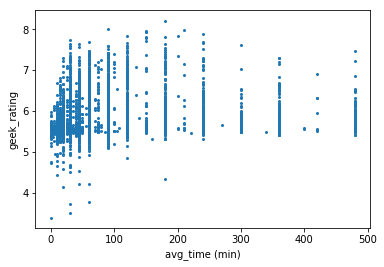

In [207]:
market_df.plot.scatter('avg_time','geek_rating',s=4)
plt.xlabel('avg_time (min)')
plt.ylabel('geek_rating')
plt.savefig('market_rating_avgtime.png')

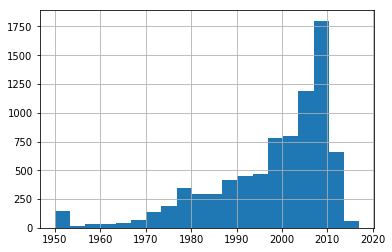

In [227]:
market_df.year.hist(bins=20)

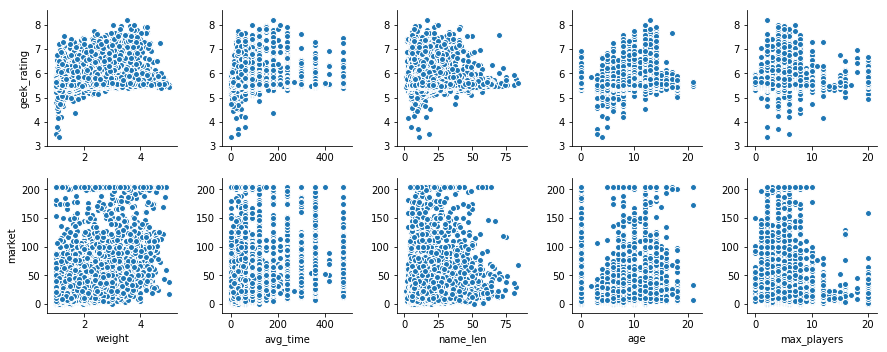

In [334]:
sns.pairplot(market_df,x_vars=['weight','avg_time','name_len','age','max_players'],
             y_vars=['geek_rating','market'])
# plt.xlabel('fontsize')
plt.savefig('top_features_targets.png')

In [198]:
columns = ['name_len','min_players','max_players','avg_time','year','age','weight','Classic'] +\
    fu.transformer_list[2][1].named_steps['countvectorizer'].get_feature_names()+\
    fu.transformer_list[3][1].named_steps['countvectorizer'].get_feature_names()+\
    fu.transformer_list[4][1].named_steps['countvectorizer'].get_feature_names()
pd.DataFrame(test_pipe.named_steps['rm'].feature_importances_,index=columns).sort_values(0,ascending=False)

0
weight                         0.179208
year                           0.075321
name_len                       0.074612
avg_time                       0.060619
age                            0.056062
Hand Management                0.034357
Card Drafting                  0.033157
max_players                    0.032735
Hex-and-Counter                0.031918
Wargame                        0.021401
Variable Player Powers         0.020549
Grid Movement                  0.019335
Economic                       0.017611
Set Collection                 0.016061
min_players                    0.015696
Dice Rolling                   0.014144
Worker Placement               0.012509
Area Control / Area Influence  0.012126
Player Elimination             0.011493
Card Game                      0.009446
Modular Board                  0.009126
Co-operative Play              0.008956
Fighting                       0.008599
Corey Konieczka                0.008508
Simultaneous Action Selection  0.007636
Area Movement                  0.007539
Industry / Manufacturing       0.007435
City Building                  0.007320
Fantasy                        0.006525
Stock Holding                  0.006486
...                                 ...
Sid Sackson                    0.000000
Stefan Dorra                   0.000000
Serge Laget                    0.000000
Mafia                          0.000000
Mike Selinker                  0.000000
Michael Rieneck                0.000000
Rock-Paper-Scissors            0.000000
Aaron Weissblum                0.000000
Vietnam War                    0.000000
Alex Randolph                  0.000000
Arabian                        0.000000
Expansion for Base-game        0.000000
D. Brad Talton Jr.             0.000000
David Sirlin                   0.000000
Game System                    0.000000
Frank Chadwick                 0.000000
Korean War                     0.000000
American Revolutionary War     0.000000
Günter Burkhardt               0.000000
Ignacy Trzewiczek              0.000000
Jack Kittredge                 0.000000
James Ernest                   0.000000
Jervis Johnson                 0.000000
Religious                      0.000000
American Indian Wars           0.000000
Leo Colovini                   0.000000
Book                           0.000000
Math                           0.000000
Michael Kiesling               0.000000
Music                          0.000000

[211 rows x 1 columns]

# Use alternative SQL dataset?

In [ ]:
# import sqlite3 as sq3

# # Read sqlite query results into a pandas DataFrame
# con = sq3.connect("datasets/database.sqlite")
# df = pd.read_sql_query('select * from BoardGames', con)

# con.close()

In [ ]:
# df.head(1)

# Use BGG API to get data for more games (including sales data)

In [19]:
# url = 'https://www.boardgamegeek.com/xmlapi2/thing?'
# ids = np.arange(110317,242510+1)
# begin_index = 0
# end_index = 100
# res = requests.get(url,{'id':1,'stats':'1','marketplace':'1','type':'boardgame'})

In [25]:
# # begin_index = 110317+1
# # end_index = 110317+100+1
# # games_list = []
# while end_index <= 242510:
#     ids = np.arange(begin_index,end_index).astype(str)
#     ids = ','.join(ids)
#     res = requests.get(url,{'id':ids,'stats':'1','marketplace':'1','type':'boardgame'})
#     d = xmltodict.parse(res.content)
#     if 'items' in d.keys():
#         if 'item' in d['items']:
#             games_list += d['items']['item']
#     print(res.status_code,end_index)
#     begin_index += 100
#     end_index += 100
#     time.sleep(5)

200 209818
200 209918
200 210018
200 210118
200 210218
200 210318
200 210418
200 210518
200 210618
200 210718
200 210818
200 210918
200 211018
200 211118
200 211218
200 211318
200 211418
200 211518
200 211618
200 211718
200 211818
200 211918
200 212018
200 212118
200 212218
200 212318
200 212418
200 212518
200 212618
200 212718
200 212818
200 212918
200 213018
200 213118
200 213218
200 213318
200 213418
200 213518
200 213618
200 213718
200 213818
200 213918
200 214018
200 214118
200 214218
200 214318
200 214418
200 214518
200 214618
200 214718
200 214818
200 214918
200 215018
200 215118
200 215218
200 215318
200 215418
200 215518
200 215618
200 215718
200 215818
200 215918
200 216018
200 216118
200 216218
200 216318
200 216418
200 216518
200 216618
200 216718
200 216818
200 216918
200 217018
200 217118
200 217218
200 217318
200 217418
200 217518
200 217618
200 217718
200 217818
200 217918
200 218018
200 218118
200 218218
200 218318
200 218418
200 218518
200 218618
200 218718
200 218818

In [125]:
#transform data from API into data frame via a dictionary
# games_dict = {col:[] for col in new_df.columns}
# for game in games_list:
#     if type(game) != str:
#         games_dict['age'].append(int(game['minage']['@value']))
#         games_dict['avg_rating'].append(float(game['statistics']['ratings']['average']['@value']))
#         games_dict['geek_rating'].append(float(game['statistics']['ratings']['bayesaverage']['@value']))
#         games_dict['num_votes'].append(float(game['statistics']['ratings']['usersrated']['@value']))
#         games_dict['numcomments'].append(float(game['statistics']['ratings']['numcomments']['@value']))
#         games_dict['numweights'].append(float(game['statistics']['ratings']['numweights']['@value']))
#         games_dict['weight'].append(float(game['statistics']['ratings']['averageweight']['@value']))
#         games_dict['wanting'].append(float(game['statistics']['ratings']['wanting']['@value']))
#         games_dict['wishing'].append(float(game['statistics']['ratings']['wishing']['@value']))
#         games_dict['trading'].append(float(game['statistics']['ratings']['trading']['@value']))
#         games_dict['avg_time'].append(int(game['playingtime']['@value']))
#         games_dict['min_time'].append(int(game['minplaytime']['@value']))
#         games_dict['max_time'].append(int(game['maxplaytime']['@value']))
#         games_dict['owned'].append(float(game['statistics']['ratings']['owned']['@value']))

#         if type(game['statistics']['ratings']['ranks']['rank']) == list:
#             games_dict['rank'].append(game['statistics']['ratings']['ranks']['rank'][0]['@value'])
#         else:
#             games_dict['rank'].append(game['statistics']['ratings']['ranks']['rank']['@value'])

#         games_dict['game_id'].append(int(game['@id']))
#         games_dict['max_players'].append(int(game['maxplayers']['@value']))
#         games_dict['min_players'].append(int(game['minplayers']['@value']))
#         games_dict['year'].append(int(game['yearpublished']['@value']))

#         if type(game['name']) == list:
#             games_dict['names'].append(game['name'][0]['@value'])
#         else:
#             games_dict['names'].append(game['name']['@value'])

#         if 'marketplacelistings' in game.keys():
#             games_dict['market'].append(game['marketplacelistings']['listing'])
#         else:
#             games_dict['market'].append('')

#         if type(game['link']) == list:
#             link = pd.DataFrame(game['link'])
#             games_dict['category'].append(', '.join(link.loc[link['@type']=='boardgamecategory','@value'].values))
#             games_dict['mechanic'].append(', '.join(link.loc[link['@type']=='boardgamemechanic','@value'].values))
#             games_dict['designer'].append(', '.join(link.loc[link['@type']=='boardgamedesigner','@value'].values))
#         else:
#             link = pd.DataFrame(game['link'],index=[0])
#             games_dict['category'].append(''.join(link.loc[link['@type']=='boardgamecategory','@value'].values))
#             games_dict['mechanic'].append(''.join(link.loc[link['@type']=='boardgamemechanic','@value'].values))
#             games_dict['designer'].append(''.join(link.loc[link['@type']=='boardgamedesigner','@value'].values))

In [128]:
# new_games = pd.DataFrame(games_dict)

In [168]:
#save data on newer games to a csv file to be read in in the future
# new_games.to_csv('datasets/new_games.csv',index=False)

In [ ]:
# res = requests.get(url,{'id':ids,'stats':'1','marketplace':'1','type':'boardgame'})
# d = xmltodict.parse(res.content)

In [14]:
#read in saved results of calls to API for game_id from 1 to 110300
new_df = pd.read_csv('datasets/bgg_full_sample.csv')
print(new_df.shape)

#read in saved results of calls to API for game_id from 110301 to 250000
new_games = pd.read_csv('datasets/new_games.csv')
print(new_games.shape)

#combine DFs into one
all_games = pd.concat([new_df,new_games],axis=0,ignore_index=True)
print(all_games.shape)

(49173, 24)
(30969, 24)
(80142, 24)


In [15]:
all_games.head()

age  avg_rating  avg_time                          category  \
0  14.0     7.65493     240.0  Economic, Negotiation, Political   
1  12.0     6.63821      30.0                Card Game, Fantasy   
2  10.0     7.43853      60.0       Abstract Strategy, Medieval   
3  12.0     6.59249      60.0                           Ancient   
4  12.0     7.35665      90.0                          Economic   

                designer  game_id  geek_rating  \
0     Karl-Heinz Schmiel        1      7.26327   
1  G. W. "Jerry" D'Arcey        2      5.86642   
2          Reiner Knizia        3      7.27475   
3      Christian Beierer        4      5.75178   
4            Sid Sackson        5      7.21202   

                                              market  max_players  max_time  \
0  OrderedDict([('listing', [OrderedDict([('listd...          5.0     240.0   
1  OrderedDict([('listing', [OrderedDict([('listd...          4.0      30.0   
2  OrderedDict([('listing', [OrderedDict([('listd...          4.0      60.0   
3  OrderedDict([('listing', [OrderedDict([('listd...          4.0      60.0   
4  OrderedDict([('listing', [OrderedDict([('listd...          6.0      90.0   

    ...   num_votes  numcomments  numweights    owned  rank  trading  wanting  \
0   ...      4588.0       1778.0       723.0   5328.0   159    178.0    521.0   
1   ...       493.0        280.0        52.0   1083.0  2646     71.0     65.0   
2   ...     12428.0       3364.0      1370.0  12427.0   157    244.0    706.0   
3   ...       317.0        113.0        30.0    539.0  3415     32.0     62.0   
4   ...     15784.0       5134.0      1527.0  19588.0   190    845.0    502.0   

   weight wishing    year  
0  4.3499  1722.0  1986.0  
1  1.9423   172.0  1981.0  
2  2.5058  2750.0  1998.0  
3  2.6667   115.0  1992.0  
4  2.5088  2289.0  1964.0  

[5 rows x 24 columns]

In [16]:
all_games.columns

Index(['age', 'avg_rating', 'avg_time', 'category', 'designer', 'game_id',
       'geek_rating', 'market', 'max_players', 'max_time', 'mechanic',
       'min_players', 'min_time', 'names', 'num_votes', 'numcomments',
       'numweights', 'owned', 'rank', 'trading', 'wanting', 'weight',
       'wishing', 'year'],
      dtype='object')

In [225]:
all_games.market[0]

'OrderedDict([(\'listing\', [OrderedDict([(\'listdate\', OrderedDict([(\'@value\', \'Wed, 26 Dec 2012 10:57:33 +0000\')])), (\'price\', OrderedDict([(\'@currency\', \'GBP\'), (\'@value\', \'74.99\')])), (\'condition\', OrderedDict([(\'@value\', \'verygood\')])), (\'notes\', OrderedDict([(\'@value\', "First edition by Hans Im Gluck (blue box) for up to 4 players.  Complete and very good condition for its age (i.e. only slight rusting on the English \'type-writer\' style printed rulebook\'s staples). Minor wear to the box.  Reasonable offers will be considered.  I can combine shipping costs with multiple items purchased.  Shiping costs are: £3.99 (UK), £9.99 (Europe), £23.99 (USA/Canada)")])), (\'link\', OrderedDict([(\'@href\', \'http://boardgamegeek.com/geekmarket/product/439030\'), (\'@title\', \'marketlisting\')]))]), OrderedDict([(\'listdate\', OrderedDict([(\'@value\', \'Fri, 11 Oct 2013 02:13:37 +0000\')])), (\'price\', OrderedDict([(\'@currency\', \'USD\'), (\'@value\', \'80.00\'

In [226]:
all_games.isnull().sum()

age                3
avg_rating         0
avg_time           3
category        1499
designer       10324
game_id            0
geek_rating        0
market         58804
max_players        3
max_time           3
mechanic       14101
min_players        3
min_time           3
names              0
num_votes          0
numcomments        0
numweights         0
owned              0
rank               0
trading            0
wanting            0
weight             0
wishing            0
year               3
dtype: int64

In [227]:
df.geek_rating.min()

5.6262699999999999

In [17]:
all_games.loc[all_games.geek_rating > 0].isnull().sum()

age               0
avg_rating        0
avg_time          0
category        150
designer        255
game_id           0
geek_rating       0
market         2582
max_players       0
max_time          0
mechanic       1466
min_players       0
min_time          0
names             0
num_votes         0
numcomments       0
numweights        0
owned             0
rank              0
trading           0
wanting           0
weight            0
wishing           0
year              0
dtype: int64

(0.5, 10.5)

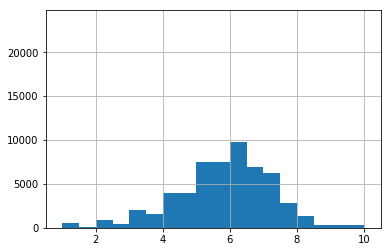

In [18]:
all_games.avg_rating.hist(bins=20)
plt.xlim(xmin=.5)

(1950, 2018)

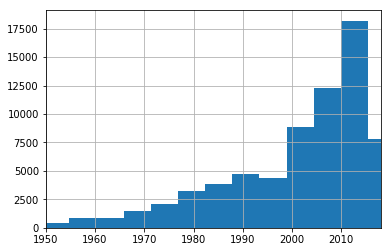

In [19]:
all_games.year.hist(bins=1000)
plt.xlim(1950,2018)

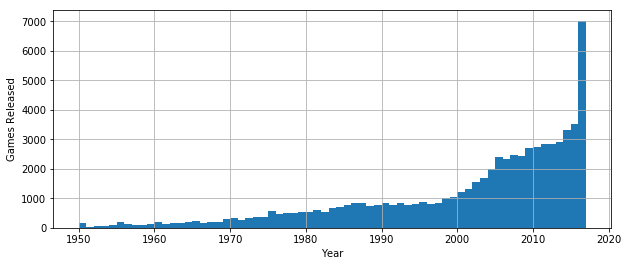

In [20]:
all_games.loc[(all_games.year>=1950) & (all_games.year<=2017),'year'].hist(bins=67,figsize=(10,4))
plt.xlabel('Year')
plt.ylabel('Games Released')
plt.savefig('plots/all_games_year_hist.png')

In [21]:
# #Get currency exchange rates for years 1999-2017 from an API
# exchange_rates = pd.DataFrame()
# for year in range(1999,2018):
#     url = 'https://api.fixer.io/{}-06-15?base=USD'.format(year)
#     res  = requests.get(url)
#     exchange_rates = pd.concat([exchange_rates,pd.DataFrame(res.json()['rates'],index=[year])])
# exchange_rates.to_csv('datasets/exchange_rates.csv')

#load previously saved exchange rates
exchange_rates = pd.read_csv('datasets/exchange_rates.csv',index_col=0)

In [22]:
def parse_market_data(s):
    years = re.findall("(\d{4}) \d{2}:",s)
    currencies = re.findall("@currency\\', \\'(\w{3})",s)
    prices = re.findall("@currency\\', \\'\w{3}\\'\), \(\\'@value\\', \\'([\d\.]+)\\'",s)
    conditions = re.findall("condition\\', OrderedDict\(\[\(\\'@value\\', \\'(\w+)\\'",s)
    market = pd.DataFrame({'year': years, 'currency': currencies, 'price': prices, 'condition': conditions})
    price_USD =  market.apply(
        lambda x: float(x.price)/exchange_rates.loc[int(x.year),x.currency] if x.currency != 'USD'\
        else float(x.price),axis=1)
    market['USD'] = price_USD.map(round)
    return price_USD.median()

In [23]:
#create new df that contains only games with a geek rating
ranked_games = all_games.loc[all_games.geek_rating > 0].copy()

#Convert max players column to be integer type
ranked_games.max_players = ranked_games.max_players.astype(int)

#aggregate available market data, taking the mean of all listings after converting to USD
ranked_games.market = ranked_games.market.map(parse_market_data,na_action='ignore')

In [24]:
ranked_games.shape

(14987, 24)

In [25]:
ranked_games.market

0         99.000000
1         40.000000
2         55.529380
3         40.588458
4         44.000000
5        175.962509
6         25.000000
7         35.396096
8         21.990000
9         27.759846
10        11.539654
11        61.412716
12        39.646928
13        22.500000
14        39.172009
15        28.610704
16              NaN
17        52.061228
18        11.865012
19       220.066033
21       120.000000
22       165.000000
23        68.128573
24        44.950000
25       112.180566
26        54.995000
27        23.448491
28       100.939614
29       237.500000
30        48.474178
            ...    
78660     57.906608
78668    111.648317
78685     22.331897
78694     64.762500
78696     49.403738
78700     22.331897
78703     33.497845
78707           NaN
78723           NaN
78728     22.220237
78738     36.847629
78750     46.896983
78801     27.803211
78821     20.098707
78832     22.627086
78837     22.220237
78862     54.249202
78903           NaN
78941           NaN


In [26]:
ranked_games.loc[ranked_games.market>500,['names','market']]

names       market
1605                                     Portal  1500.000000
2255                            Poisson d'Avril  3466.000000
3333                           Ultimate Combat!  2851.773351
3554    The Wheel of Time Collectible Card Game  1999.990000
5949                                      Zendo  4519.710000
8167                                  IceTowers  4525.210000
8383                                   Gnostica  9000.420000
11490                                   Volcano  9000.420000
11897             Warzone: Universe Under Siege  9999.000000
12824                                Homeworlds  9000.420000
13345                                   RAMbots  9000.420000
14947                  La Bataille d'Austerlitz   800.000000
15268              CATAN 3D Collector's Edition   669.956899
17318                             Martian Chess  9000.420000
17712                                   Pikemen  9000.420000
18093   Capes & Cowls: The Superhero Board Game   505.351107
18493                                  Thin Ice  9000.420000
25508                                 Case Blue   526.233837
39380       War of the Ring Collector's Edition  1889.406726
56095     Sergeants Miniatures Game: Red Devils   675.000000
57070              Small World Designer Edition  1683.380687
62305                  Folklore: The Affliction   513.633623
74451  Shadows of Brimstone: Forbidden Fortress   993.769401
75098         Dominion (Second Edition) Big Box   577.500000

In [27]:
#clip values more than 3 sigma from the mean and mark them as NA; do this in two successive rounds
for _ in range(2):
    sigma = ranked_games.market.std()
    mean = ranked_games.market.mean()
    ranked_games.market = ranked_games.market.map(lambda x: mean+3*sigma if abs(x-mean) > 3*sigma else x)

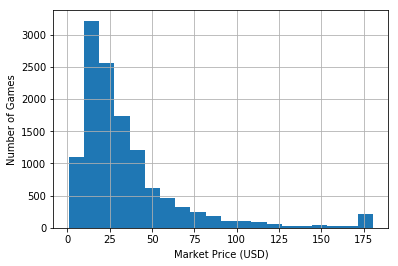

In [28]:
ranked_games.market.hist(bins=20)
plt.xlabel('Market Price (USD)')
plt.ylabel('Number of Games')
plt.savefig('plots/market_price_hist.png')

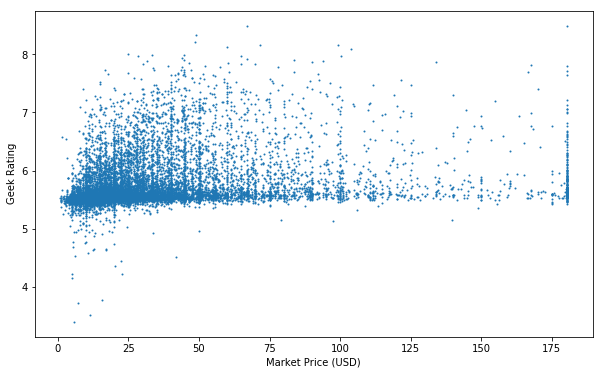

In [30]:
ranked_games.plot.scatter('market','geek_rating',s=1,figsize=(10,6))
plt.xlabel('Market Price (USD)')
plt.ylabel('Geek Rating')
plt.savefig('plots/rating_price.png')

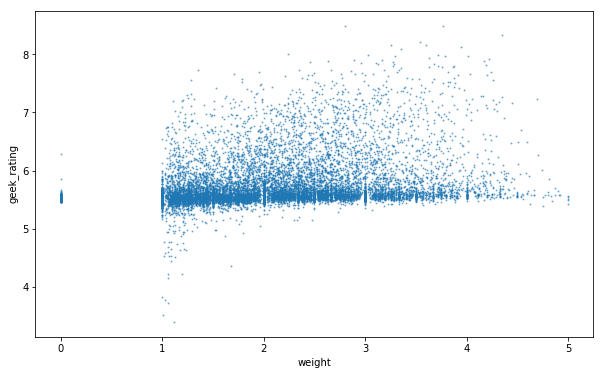

In [31]:
ranked_games.plot.scatter('weight','geek_rating',s=1,alpha=.5,figsize=(10,6))

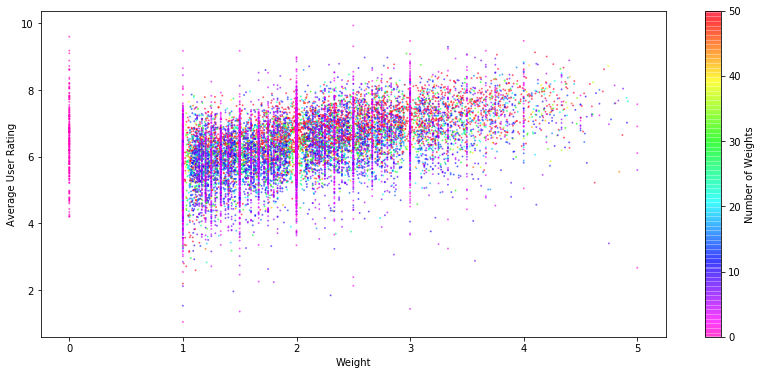

In [32]:
plt.figure(figsize=(14,6))
numweights = ranked_games.numweights.map(lambda x: min(x,50))
plt.scatter(ranked_games.weight,ranked_games.avg_rating,s=1,alpha=.5,c=numweights,cmap='gist_rainbow_r')
plt.colorbar(label='Number of Weights')
plt.xlabel('Weight')
plt.ylabel('Average User Rating')
plt.show()

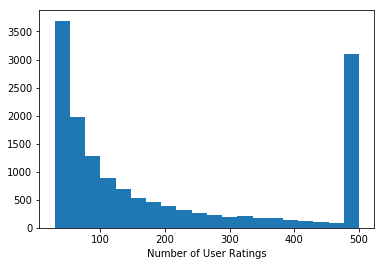

In [33]:
numvotes = ranked_games.num_votes.map(lambda x: min(x,500))
plt.hist(numvotes,bins=20)
plt.xlabel('Number of User Ratings')
plt.show()

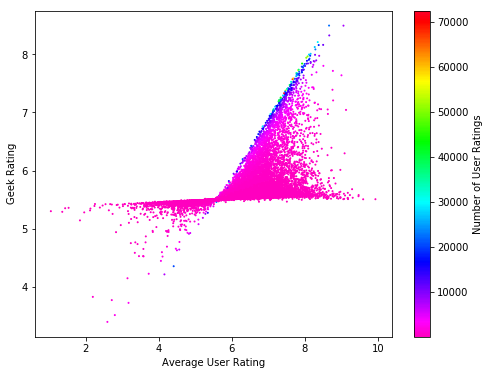

In [34]:
plt.figure(figsize=(8,6))
plt.scatter(ranked_games.avg_rating,ranked_games.geek_rating,c=ranked_games.num_votes,cmap='gist_rainbow_r',s=1)
plt.xlabel('Average User Rating')
plt.ylabel('Geek Rating')
plt.colorbar(label='Number of User Ratings')
plt.savefig('plots/geek_avg_numvotes.png')

In [35]:
numvotes.min()

30.0

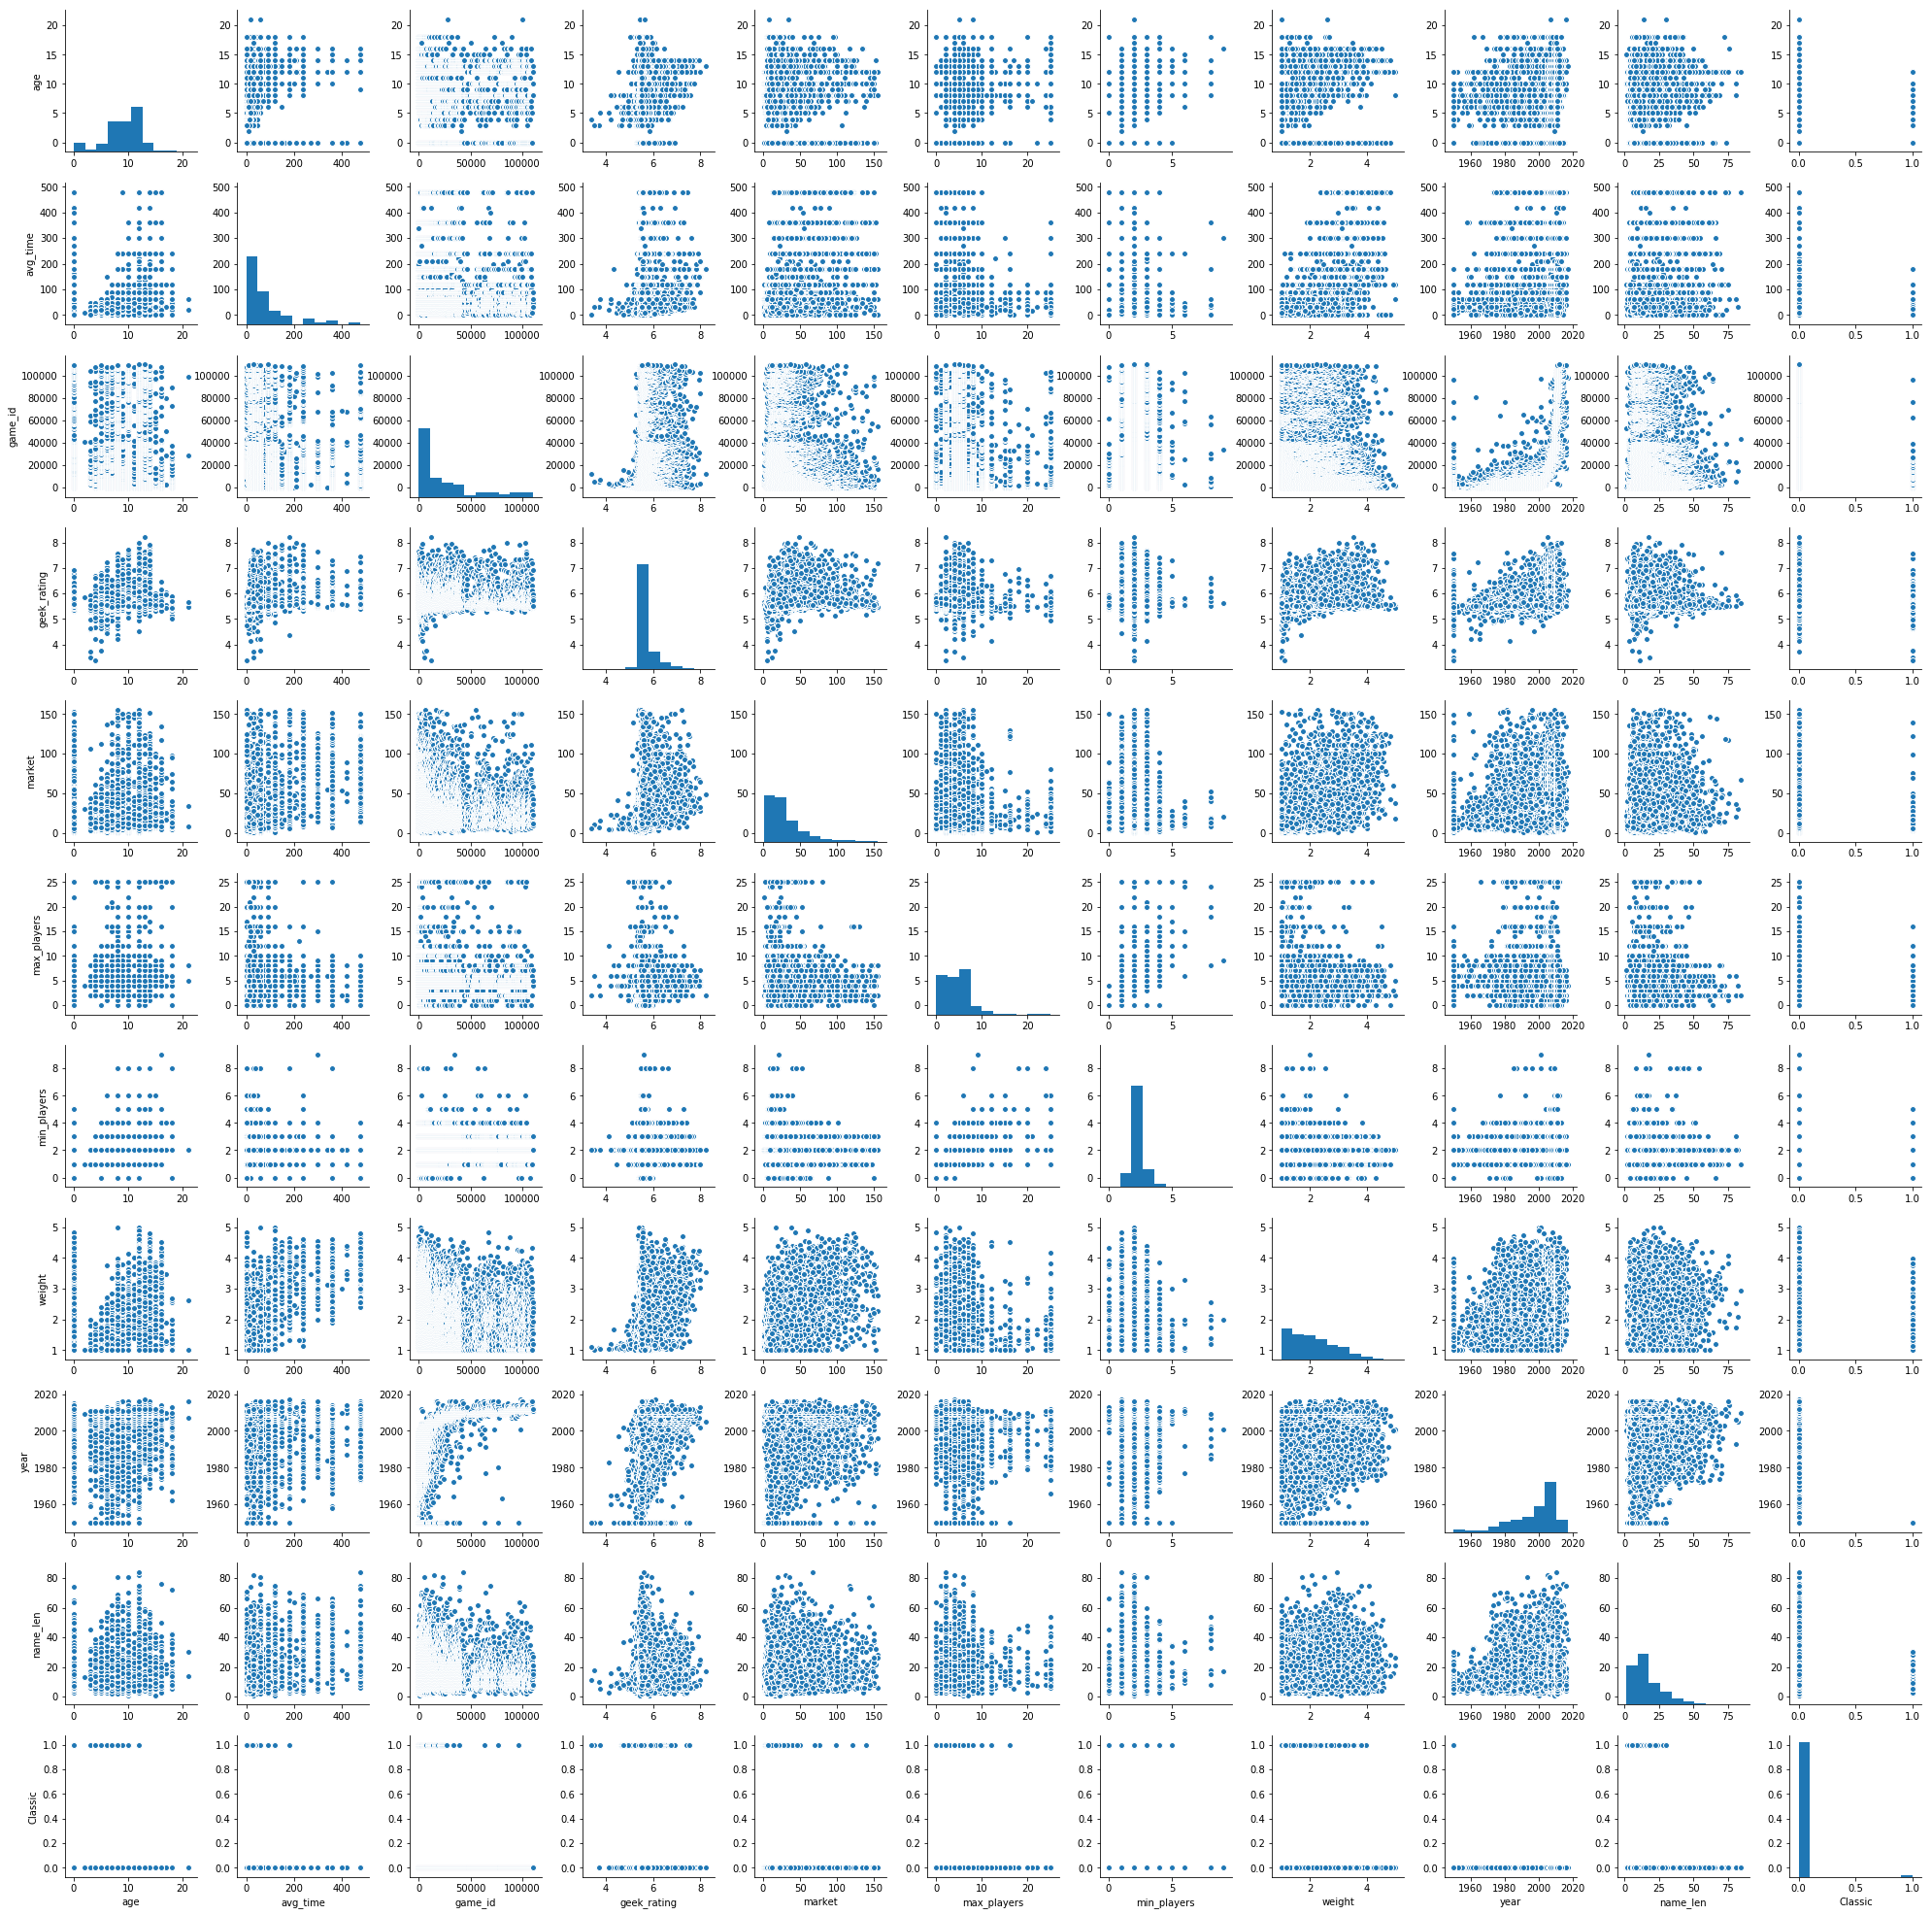

In [115]:
sns.pairplot(market_df)
plt.savefig('pairplot.png')

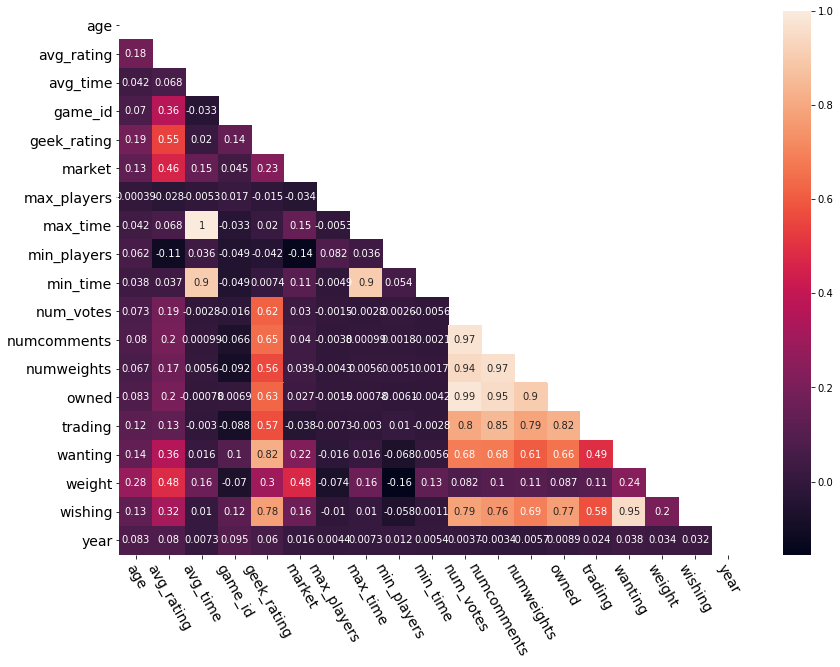

In [36]:
corr = ranked_games.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(14,10))
sns.heatmap(corr,mask=mask,annot=True)
plt.tick_params(axis='both',labelsize=14)
plt.xticks(rotation=300)
plt.savefig('ranked_df_heatmap.png')

In [37]:
#number of geek-rated games with no market data or eroneous data
ranked_games.market.isnull().sum()

2582

In [38]:
#number of games with a geek rating
len(ranked_games)

14987

In [39]:
#number of games with no geek rating
all_games.loc[all_games.geek_rating == 0, 'geek_rating'].count()

65155

In [347]:
#Number of games with no user ratings
all_games.loc[all_games.avg_rating == 0, 'avg_rating'].count()

23586

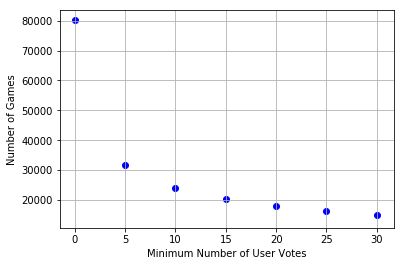

In [51]:
#Number of games with at least 5 user ratings
for votes in np.arange(0,31,5):
    plt.scatter(votes,all_games.loc[all_games.num_votes >= votes, 'avg_rating'].count(),c='b')
plt.xlabel('Minimum Number of User Votes')
plt.ylabel('Number of Games')
plt.grid()
plt.savefig('plots/games_votes.png')

In [52]:
ranked_games.dtypes

age            float64
avg_rating     float64
avg_time       float64
category        object
designer        object
game_id          int64
geek_rating    float64
market         float64
max_players      int32
max_time       float64
mechanic        object
min_players    float64
min_time       float64
names           object
num_votes      float64
numcomments    float64
numweights     float64
owned          float64
rank            object
trading        float64
wanting        float64
weight         float64
wishing        float64
year           float64
dtype: object

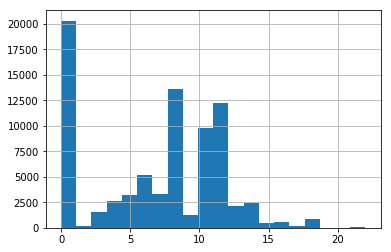

In [53]:
all_games.loc[all_games.age<25,'age'].hist(bins=20)

In [54]:
ranked_games.drop(['avg_rating','num_votes','numcomments','min_time','max_time','numweights','owned',
                  'rank','trading','wanting','wishing'],axis=1,inplace=True)

In [55]:
ranked_games['name_len'] = ranked_games.names.map(lambda x: len(x))
ranked_games.drop('names',axis=1,inplace=True)

In [56]:
#Create year cuttoff of 1950 and mark gams released before 1900 as 'classic'
ranked_games['Classic'] = ranked_games.year.map(lambda x: 1 if x < 1900 else 0)
ranked_games.year = ranked_games.year.map(lambda x: 1950 if x < 1950 else x)

In [57]:
#Set cap on max_players of 20
ranked_games.max_players = ranked_games.max_players.map(lambda x: min(x,20))

#Enforce a cutoff for the avg_time of 8 hours (480 min)
ranked_games.avg_time = ranked_games.avg_time.map(lambda x: min(x,480))

#Set suggested minimum age to have a cutoff of 21 years old
ranked_games.age = ranked_games.age.map(lambda x: min(x,21))

#Change games with 'none' for designer to '(Uncredited)
ranked_games.loc[(ranked_games.designer=='none') | (ranked_games.designer=='(Uncredited)'),'designer'] = 'Designer Unknown'
ranked_games.loc[ranked_games.mechanic=='none','mechanic'] = 'Mechanic Unknown'
ranked_games.loc[ranked_games.category=='none','category'] = 'Category Unknown'

#Impute missing values in weight column with median
ranked_games.loc[ranked_games.weight==0,'weight'] = ranked_games.loc[ranked_games.weight>0,'weight'].median()

In [58]:
market_df = ranked_games.loc[~ranked_games.market.isnull()].copy()

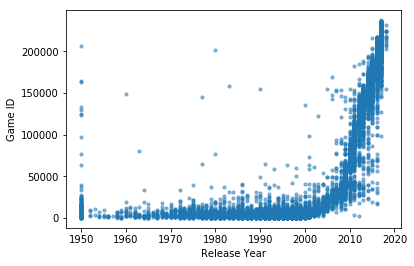

In [59]:
market_df.plot.scatter('year','game_id',alpha=.5,s=10)
plt.xlabel('Release Year')
plt.ylabel('Game ID')
plt.savefig('market_id_year.pdf')

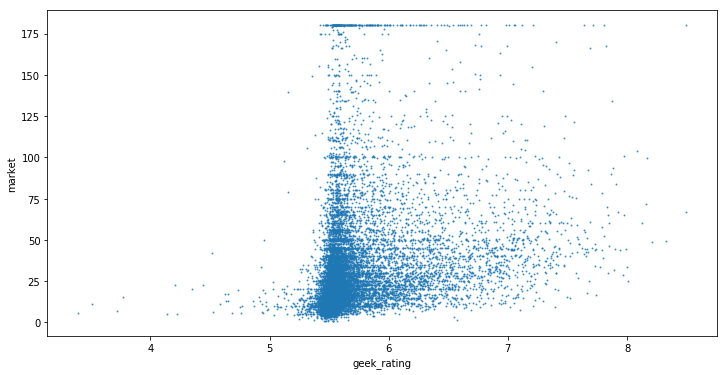

In [60]:
market_df.plot.scatter('geek_rating','market',s=1,alpha=.7,figsize=(12,6))

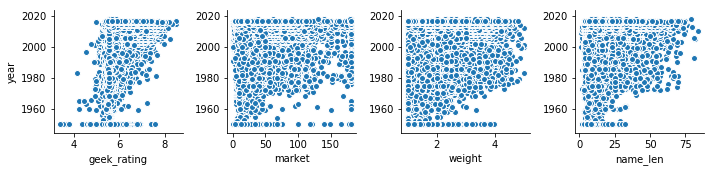

In [61]:
sns.pairplot(market_df,y_vars='year',x_vars=['geek_rating','market','weight','name_len'])
plt.savefig('market_year_pairplot.png')

In [62]:
market_df.shape

(12405, 14)

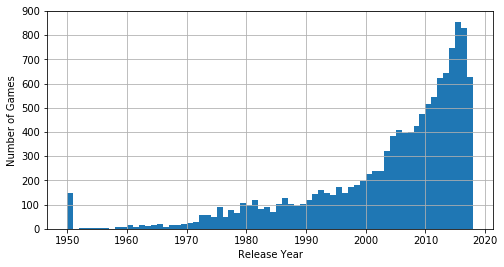

In [77]:
market_df.year.hist(bins=68,figsize=(8,4))
plt.xlabel('Release Year')
plt.ylabel('Number of Games')
plt.savefig('plots/market_year_hist.png')

In [65]:
market_df.isnull().sum()

age               0
avg_time          0
category        121
designer        159
game_id           0
geek_rating       0
market            0
max_players       0
mechanic       1101
min_players       0
weight            0
year              0
name_len          0
Classic           0
dtype: int64

In [66]:
market_df.category.fillna('Category Unknown',inplace=True)
market_df.designer.fillna('Designer Unknown',inplace=True)
market_df.mechanic.fillna('Mechanic Unknown',inplace=True)

In [67]:
market_df.isnull().sum()

age            0
avg_time       0
category       0
designer       0
game_id        0
geek_rating    0
market         0
max_players    0
mechanic       0
min_players    0
weight         0
year           0
name_len       0
Classic        0
dtype: int64

In [118]:
market_df.

age                9.697219
avg_time          76.761951
game_id        72110.795083
geek_rating        5.746494
market            34.549587
max_players        4.701330
min_players        2.056751
weight             2.108168
year            2003.246755
name_len          17.358888
Classic            0.007336
dtype: float64

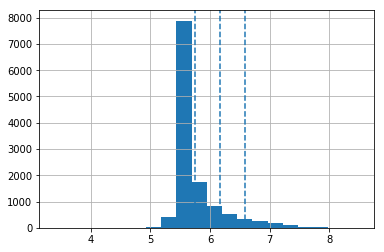

In [122]:
market_df.geek_rating.hist(bins=20)
plt.axvline(market_df.geek_rating.mean(),linestyle='--')
plt.axvline(market_df.geek_rating.mean()+market_df.geek_rating.std(),linestyle='--')
plt.axvline(market_df.geek_rating.mean()+2*market_df.geek_rating.std(),linestyle='--')

In [124]:
#binarize geek rating column so that "good games" that have a rating greater than 1 sd from the mean have a value 
#of 1 
cutoff = market_df.geek_rating.mean() + market_df.geek_rating.std()
market_df['gg'] = market_df.geek_rating.map(lambda x: 1 if x > cutoff else 0)

In [129]:
#classification baseline accuracy
1-market_df.gg.mean()

0.8742442563482467

In [130]:
X = market_df.drop(['geek_rating','game_id','market','gg'],axis=1)
y = market_df.gg.copy()

X_use, X_hold, y_use, y_hold = train_test_split(X,y,test_size=.2)
X_train, X_test, y_train, y_test = train_test_split(X_use,y_use,test_size=.2)

In [80]:
#Establish a baseline score (rmse) using the mean geek_ratig as a prediction for all games
print('Baseline RMSE (train):',mean_squared_error(y_train,[y_train.mean() for _ in y_train])**.5)
print('Baseline RMSE (test):',mean_squared_error(y_test,[y_test.mean() for _ in y_test])**.5) 

Baseline RMSE (train): 32.0678499494
Baseline RMSE (test): 31.8326896661


In [134]:
#wargames
market_df.loc[market_df.category.str.contains('War'),['market','geek_rating','gg']].mean()

market         50.773286
geek_rating     5.702519
gg              0.072727
dtype: float64

In [135]:
#not wargames
market_df.loc[~market_df.category.str.contains('War'),['market','geek_rating','gg']].mean()

market         30.046717
geek_rating     5.758699
gg              0.140474
dtype: float64

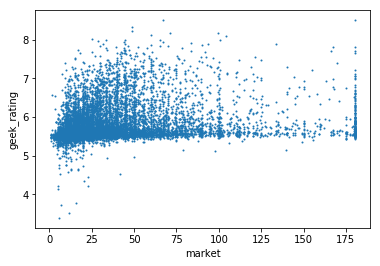

In [496]:
market_df.plot.scatter('market','geek_rating',s=1)

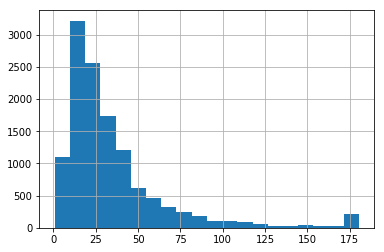

In [81]:
np.exp(y).hist(bins=20)

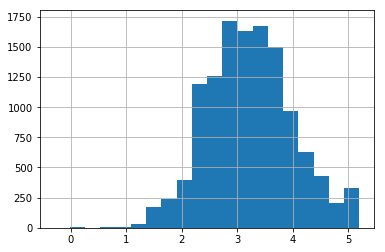

In [82]:
y.hist(bins=20)

In [139]:
pipe = Pipeline([
    ('fu', fu),
#     ('rf', RandomForestRegressor(min_samples_leaf=5,max_features=1/3,n_estimators=75)),
#     ('svd', TruncatedSVD()),
    ('gs', GridSearchCV(RandomForestClassifier(),
            param_grid={'min_samples_leaf':[3,5,7],
                       'n_estimators':np.arange(25,151,25),
                       'max_features':[None,1/3]},
#             scoring='neg_mean_squared_error',
            verbose=2,
            return_train_score=True))
])

In [140]:
pipe.fit(X_train,y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] max_features=None, min_samples_leaf=3, n_estimators=25 ..........
[CV]  max_features=None, min_samples_leaf=3, n_estimators=25, total=   1.9s
[CV] max_features=None, min_samples_leaf=3, n_estimators=25 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  max_features=None, min_samples_leaf=3, n_estimators=25, total=   2.0s
[CV] max_features=None, min_samples_leaf=3, n_estimators=25 ..........
[CV]  max_features=None, min_samples_leaf=3, n_estimators=25, total=   1.9s
[CV] max_features=None, min_samples_leaf=3, n_estimators=50 ..........
[CV]  max_features=None, min_samples_leaf=3, n_estimators=50, total=   3.8s
[CV] max_features=None, min_samples_leaf=3, n_estimators=50 ..........
[CV]  max_features=None, min_samples_leaf=3, n_estimators=50, total=   3.9s
[CV] max_features=None, min_samples_leaf=3, n_estimators=50 ..........
[CV]  max_features=None, min_samples_leaf=3, n_estimators=50, total=   3.9s
[CV] max_features=None, min_samples_leaf=3, n_estimators=75 ..........
[CV]  max_features=None, min_samples_leaf=3, n_estimators=75, total=   6.1s
[CV] max_features=None, min_samples_leaf=3, n_estimators=75 ..........
[CV]  max_features=None, min_samples_leaf=3, n_estimators=75, total=   5.7s
[CV] max_features=None, min_samples_leaf=3

[CV]  max_features=0.3333333333333333, min_samples_leaf=3, n_estimators=50, total=   1.8s
[CV] max_features=0.3333333333333333, min_samples_leaf=3, n_estimators=50 
[CV]  max_features=0.3333333333333333, min_samples_leaf=3, n_estimators=50, total=   1.5s
[CV] max_features=0.3333333333333333, min_samples_leaf=3, n_estimators=50 
[CV]  max_features=0.3333333333333333, min_samples_leaf=3, n_estimators=50, total=   1.7s
[CV] max_features=0.3333333333333333, min_samples_leaf=3, n_estimators=75 
[CV]  max_features=0.3333333333333333, min_samples_leaf=3, n_estimators=75, total=   2.6s
[CV] max_features=0.3333333333333333, min_samples_leaf=3, n_estimators=75 
[CV]  max_features=0.3333333333333333, min_samples_leaf=3, n_estimators=75, total=   2.5s
[CV] max_features=0.3333333333333333, min_samples_leaf=3, n_estimators=75 
[CV]  max_features=0.3333333333333333, min_samples_leaf=3, n_estimators=75, total=   2.4s
[CV] max_features=0.3333333333333333, min_samples_leaf=3, n_estimators=100 
[CV]  max

[CV]  max_features=0.3333333333333333, min_samples_leaf=7, n_estimators=150, total=   3.6s


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  8.0min finished


Pipeline(memory=None,
     steps=[('fu', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipe', Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor(column=['name_len', 'min_players', 'max_players', 'avg_time', 'year', 'age', 'weight'])), ('functiontransformer', FunctionTransformer(accept_sparse=False...     pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2))])

In [98]:
print(mean_squared_error(np.exp(y_test),np.exp(pipe.predict(X_test)))**.5)
print(mean_squared_error(np.exp(y_hold),np.exp(pipe.predict(X_hold)))**.5)

25.5050635715
26.3222673773


In [141]:
gs_results = pd.DataFrame({
    'train_score': pipe.named_steps['gs'].cv_results_['mean_train_score'],
    'test_score': pipe.named_steps['gs'].cv_results_['mean_test_score'],
    'max_features': pipe.named_steps['gs'].cv_results_['param_max_features'],
    'min_samples_leaf': pipe.named_steps['gs'].cv_results_['param_min_samples_leaf'],
    'n_estimators': pipe.named_steps['gs'].cv_results_['param_n_estimators']
})

# gs_results['train_score'] = np.exp(abs(gs_results['train_score'])**.5)
# gs_results['test_score'] = np.exp(abs(gs_results['test_score'])**.5)
gs_results['score_diff'] = abs(gs_results.test_score - gs_results.train_score)
gs_results.sort_values('test_score',ascending=False).head(20)

max_features min_samples_leaf n_estimators  test_score  train_score  \
12         None                7           25    0.882353     0.920141   
2          None                3           75    0.882227     0.960386   
3          None                3          100    0.882227     0.959315   
8          None                5           75    0.881723     0.934249   
4          None                3          125    0.881597     0.960448   
21     0.333333                3          100    0.881597     0.946719   
5          None                3          150    0.881471     0.959504   
6          None                5           25    0.881471     0.933871   
22     0.333333                3          125    0.881345     0.947034   
10         None                5          125    0.881345     0.935508   
24     0.333333                5           25    0.881093     0.920897   
23     0.333333                3          150    0.880841     0.946908   
27     0.333333                5          100    0.880715     0.919511   
11         None                5          150    0.880715     0.935382   
20     0.333333                3           75    0.880589     0.947285   
14         None                7           75    0.880464     0.918944   
7          None                5           50    0.880338     0.933745   
19     0.333333                3           50    0.880086     0.946152   
18     0.333333                3           25    0.880086     0.945774   
9          None                5          100    0.879960     0.934878   

    score_diff  
12    0.037788  
2     0.078159  
3     0.077088  
8     0.052525  
4     0.078851  
21    0.065121  
5     0.078032  
6     0.052400  
22    0.065688  
10    0.054163  
24    0.039804  
23    0.066066  
27    0.038796  
11    0.054667  
20    0.066696  
14    0.038481  
7     0.053407  
19    0.066066  
18    0.065688  
9     0.054919

In [399]:
print('Train RMSE:',mean_squared_error(y_train,pipe.predict(X_train))**.5)
print('Test RMSE:',mean_squared_error(y_test,pipe.predict(X_test))**.5)

Train RMSE: 0.121499521767
Test RMSE: 0.316279764753


In [408]:
pipe.named_steps['gs'].best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.3333333333333333, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [142]:
columns = ['name_len','min_players','max_players','avg_time','year','age','weight','Classic'] +\
    fu.transformer_list[2][1].named_steps['countvectorizer'].get_feature_names()+\
    fu.transformer_list[3][1].named_steps['countvectorizer'].get_feature_names()+\
    fu.transformer_list[4][1].named_steps['countvectorizer'].get_feature_names()
feature_importances = pd.DataFrame(pipe.named_steps['gs'].best_estimator_.feature_importances_,index=columns).sort_values(0,ascending=False)
feature_importances.loc[feature_importances[0]>=0.01]

0
weight                         0.245428
year                           0.106234
name_len                       0.083816
Hex-and-Counter                0.055264
avg_time                       0.044198
Hand Management                0.043235
age                            0.039372
max_players                    0.034069
Wargame                        0.028830
Variable Player Powers         0.018114
Card Drafting                  0.017419
Worker Placement               0.016352
Set Collection                 0.014738
Area Control / Area Influence  0.014270
Player Elimination             0.012209
Grid Movement                  0.011173
Dice Rolling                   0.010468
min_players                    0.010352
City Building                  0.010234

In [144]:
#calculate RMSE for the holdout set
accuracy_score(y_hold,pipe.predict(X_hold))

0.87787182587666268

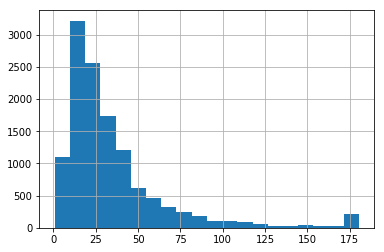

In [412]:
market_df.market.hist(bins=20)

In [56]:
abs(mean_squared_error(y_hold,pipe.predict(X_hold)))**.5

0.28851501570823923

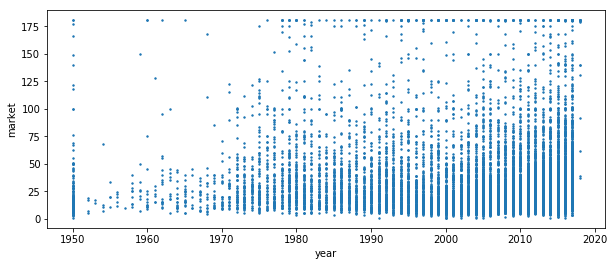

In [416]:
market_df.plot.scatter('year','market',s=2,figsize=(10,4))

In [418]:
##have to change the return value of the parse_maret_data fct to get this cell to work - calculates prices grouped
##by game condition
# foo = parse_market_data(all_games.market[0])
# foo.drop(['currency','price'],axis=1,inplace=True)
# print('median:',foo.USD.median(),'std:',foo.USD.std())
# foo.year = foo.year.astype(int)
# foo.groupby('condition').agg(['median','std','count'])

Text(0,0.5,'Geek Rating')

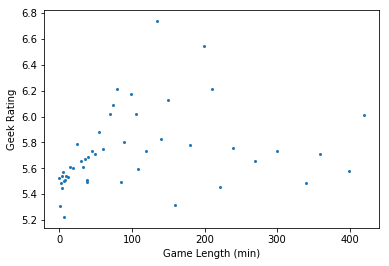

In [265]:
bins = np.linspace(market_df.avg_time.min(),market_df.avg_time.max(),500)
ratings = []
for i in range(len(bins)-1):
    ratings.append(market_df.loc[(market_df.avg_time>=bins[i]) & (market_df.avg_time<bins[i+1]),'geek_rating'].mean())
plt.scatter(bins[:-1],ratings,s=4)
plt.xlabel('Game Length (min)')
plt.ylabel('Geek Rating')

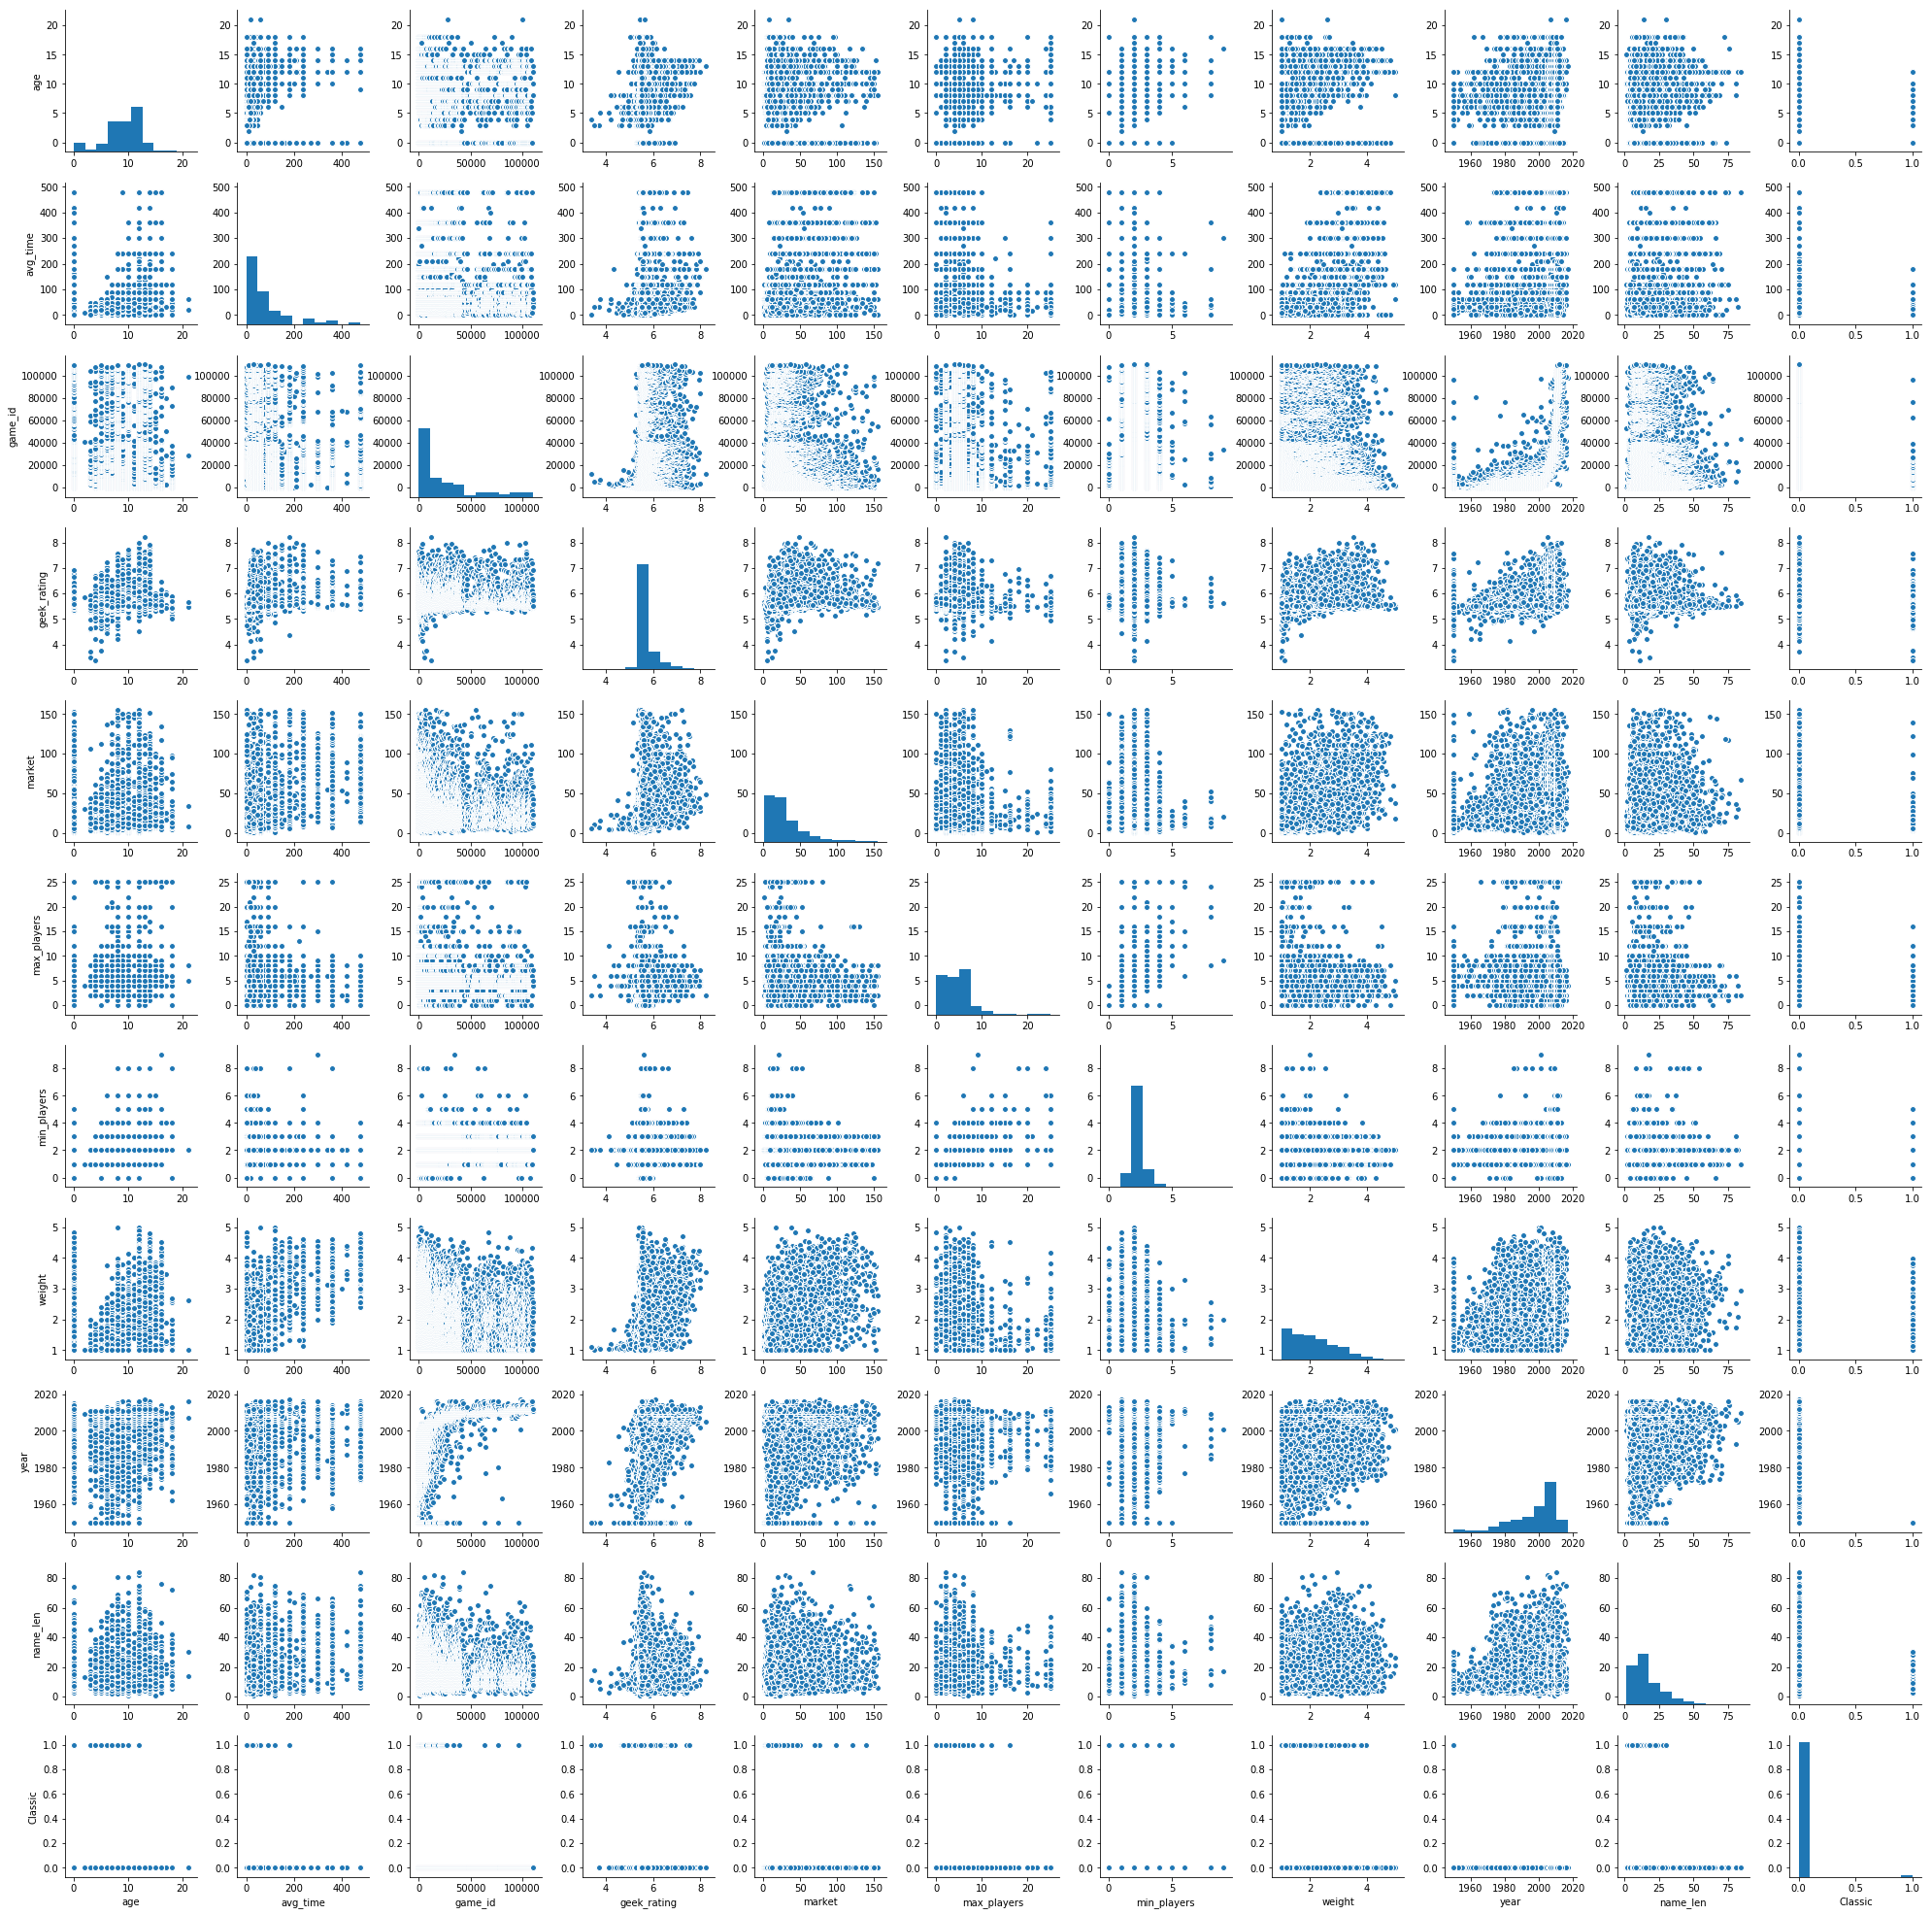

In [138]:
sns.pairplot(market_df)

In [102]:
X_train_tr = fu.fit_transform(X_train).todense()
X_test_tr = fu.transform(X_test).todense()

In [197]:
model = Sequential()
model.add(Dense(X_train_tr.shape[1],input_dim=X_train_tr.shape[1],activation='relu'))
model.add(Dropout(.25))
model.add(Dense(round(X_train_tr.shape[1]/2),activation='relu'))
model.add(Dense(25,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train_tr, y_train, validation_data=(X_test_tr,y_test), epochs=10)

Train on 3936 samples, validate on 1687 samples
Epoch 1/10
3936/3936 [==============================] - 1s 219us/step - loss: 733.6777 - val_loss: 424.3334
Epoch 2/10
3936/3936 [==============================] - 0s 94us/step - loss: 462.0692 - val_loss: 412.5471
Epoch 3/10
3936/3936 [==============================] - 0s 94us/step - loss: 431.7302 - val_loss: 442.4522
Epoch 4/10
3936/3936 [==============================] - 0s 102us/step - loss: 417.4384 - val_loss: 408.9390
Epoch 5/10
3936/3936 [==============================] - 0s 100us/step - loss: 398.5460 - val_loss: 407.7906
Epoch 6/10
3936/3936 [==============================] - 0s 104us/step - loss: 377.8633 - val_loss: 400.6680
Epoch 7/10
3936/3936 [==============================] - 0s 104us/step - loss: 360.4426 - val_loss: 410.7293
Epoch 8/10
3936/3936 [==============================] - 0s 96us/step - loss: 334.1403 - val_loss: 404.9158
Epoch 9/10
3936/3936 [==============================] - 0s 94us/step - loss: 312.5720 - val

In [196]:
397**.5

19.924858845171276

In [103]:
X_train_tr.shape

(7939, 399)

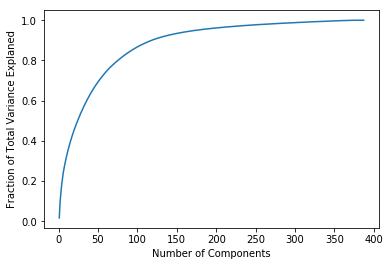

In [421]:
svd = TruncatedSVD(X_train_tr.shape[1]-1)
X_svd = svd.fit_transform(X_train_tr)
components = np.arange(1,X_train_tr.shape[1])
var = svd.explained_variance_ratio_.cumsum()
plt.plot(components,var)
plt.xlabel('Number of Components')
plt.ylabel('Fraction of Total Variance Explaned')
plt.savefig('plots/market_svd.png')

In [104]:
svd = TruncatedSVD(2)
X_2d = svd.fit_transform(X_train_tr)

In [112]:
km = KMeans(2)
km.fit(X_2d)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [106]:
y_train[km.labels_==1].mean(),y_train[km.labels_==0].mean()

(52.776553777728225, 30.11022842130979)

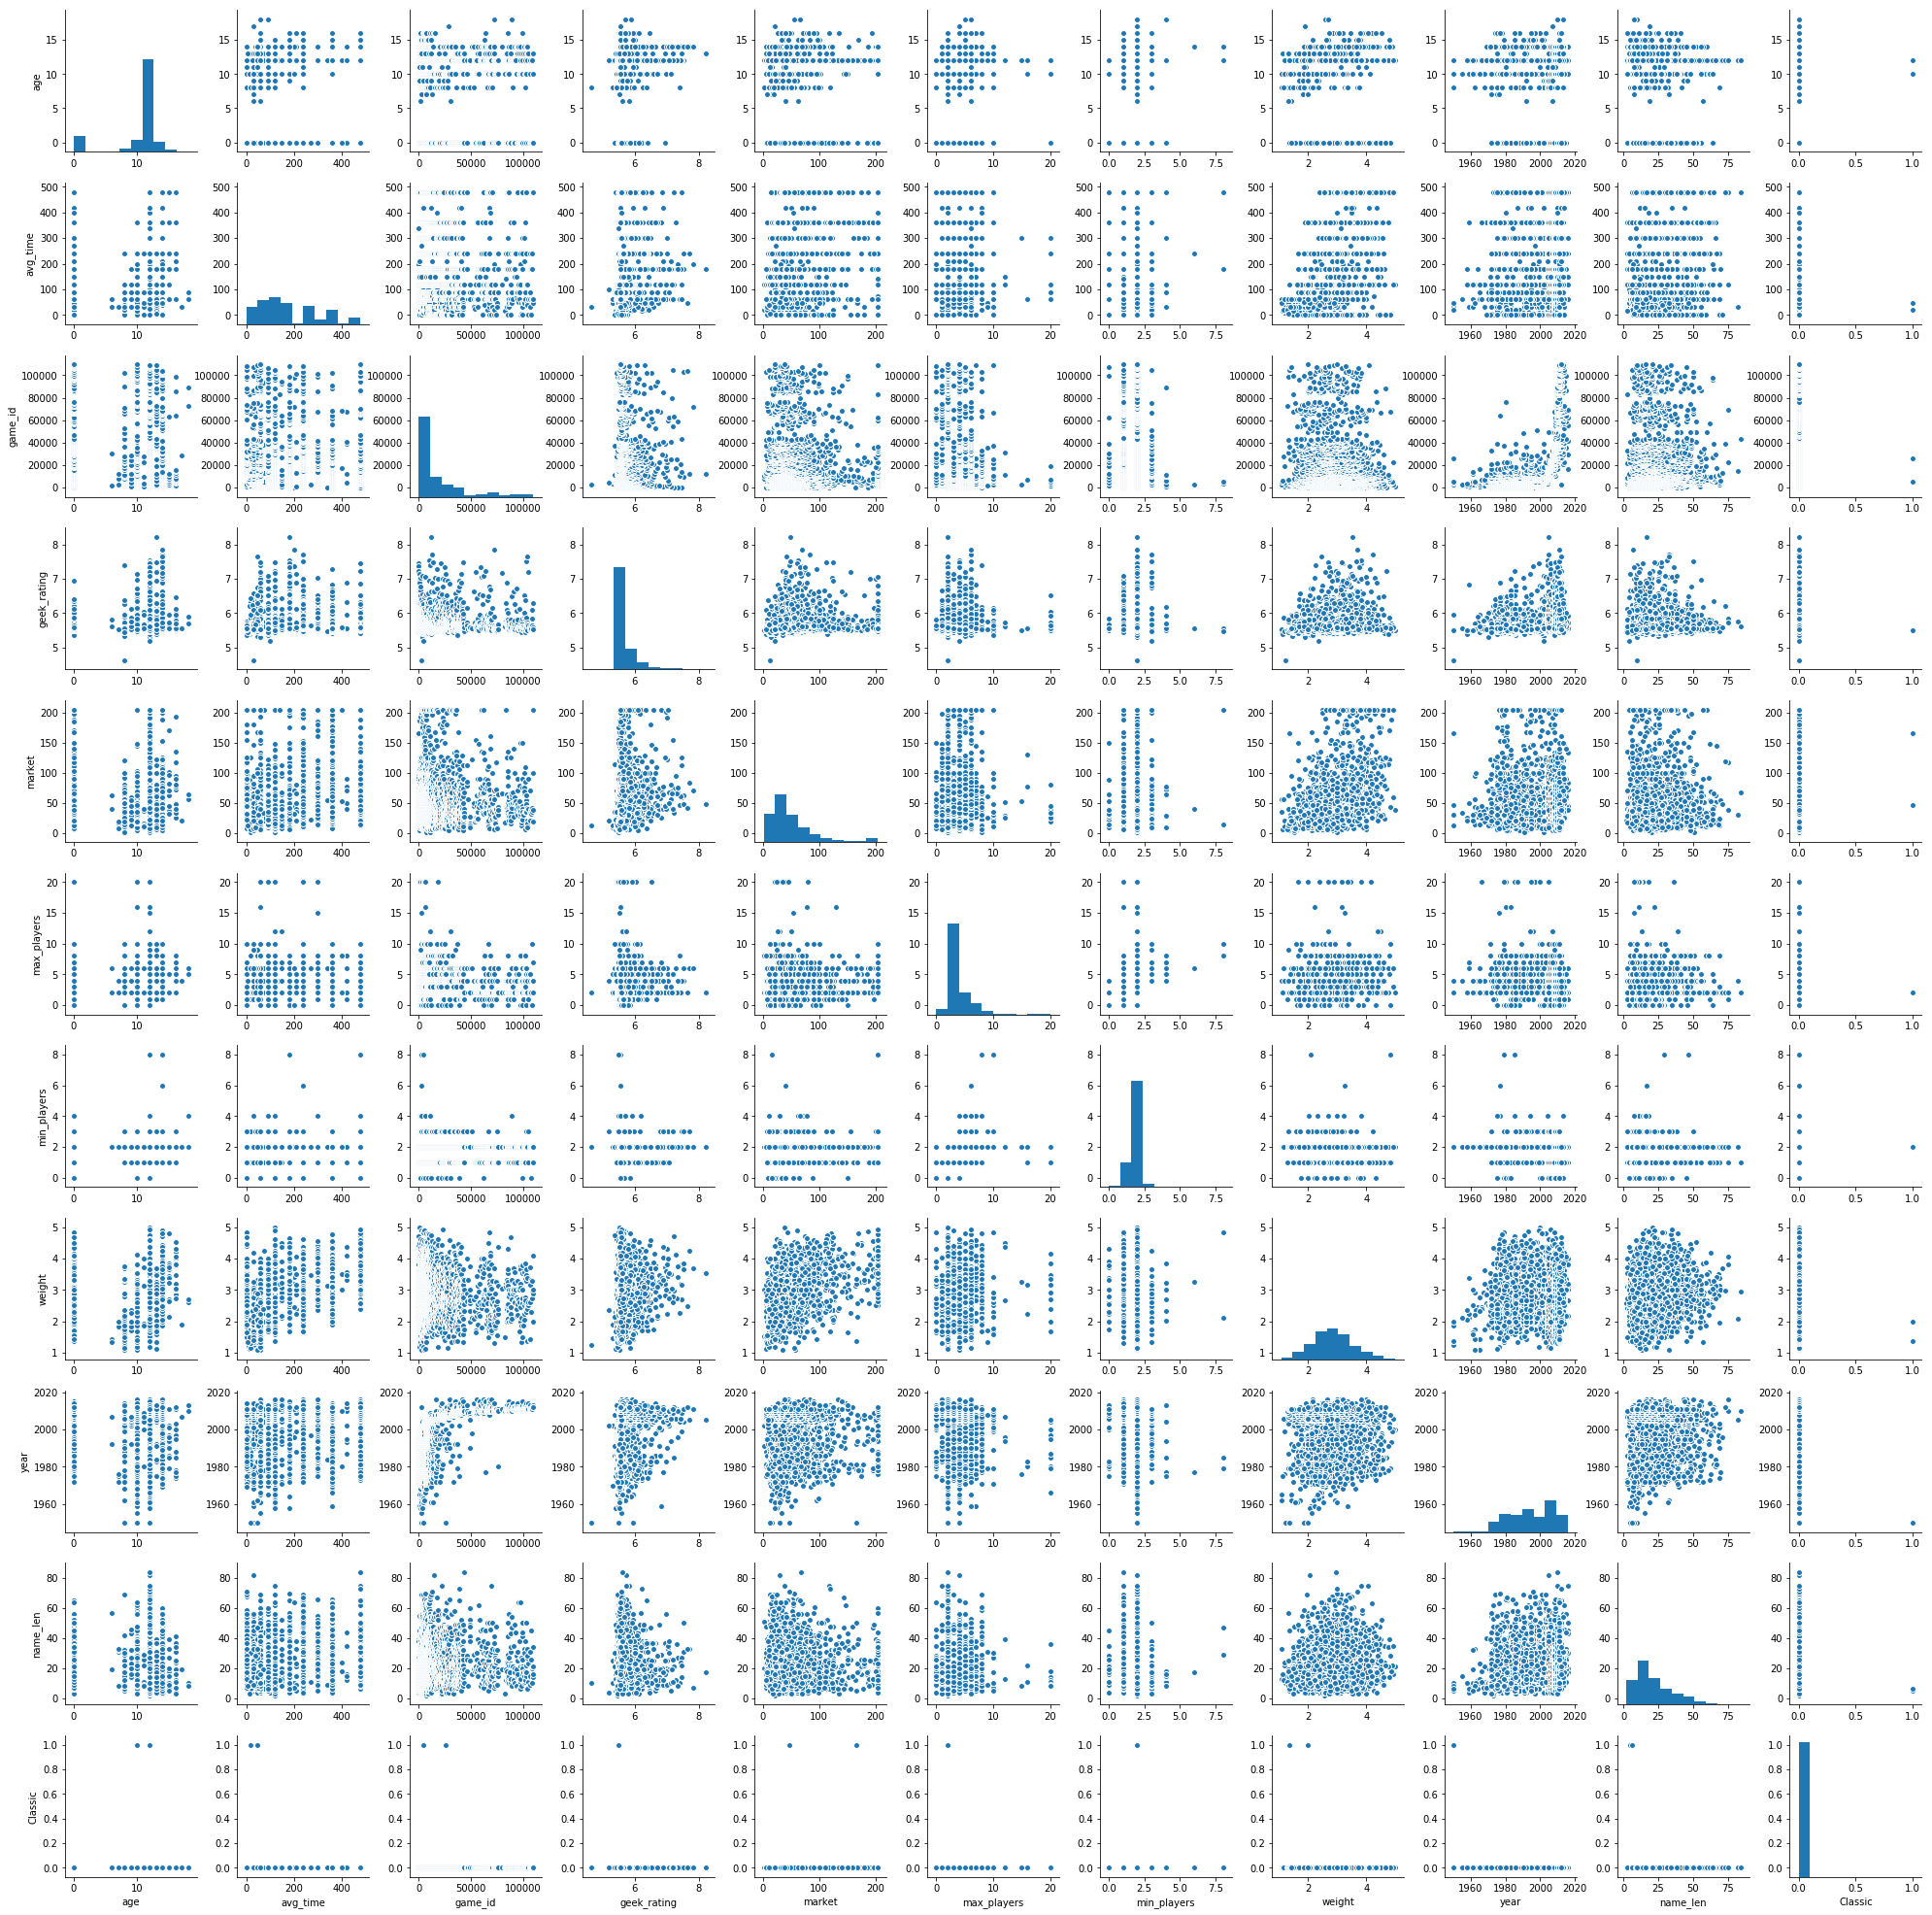

In [332]:
sns.pairplot(market_df.loc[market_df.category.str.contains('War')])

In [331]:
market_df.loc[~market_df.category.str.contains('War'),'market'].mean()

27.89373391992493

Text(0,0.5,'SVD Component 2')

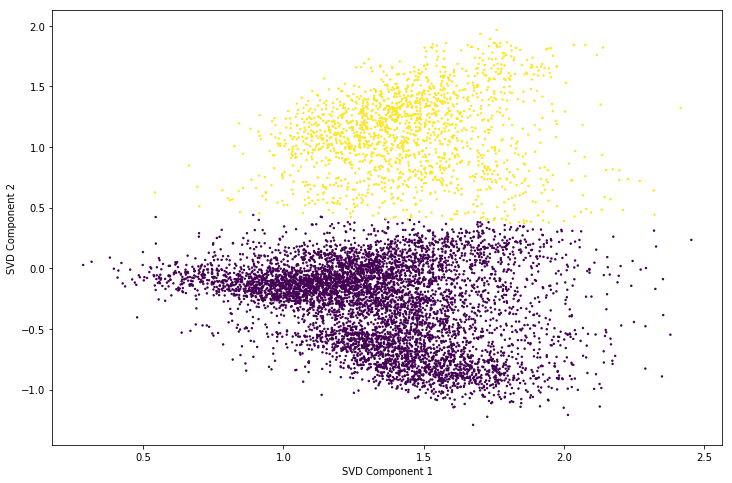

In [113]:
plt.figure(figsize=(12,8))
plt.scatter(X_2d[:,0],X_2d[:,1],c=km.labels_,s=2)
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
# plt.savefig('svd_clusters.png')

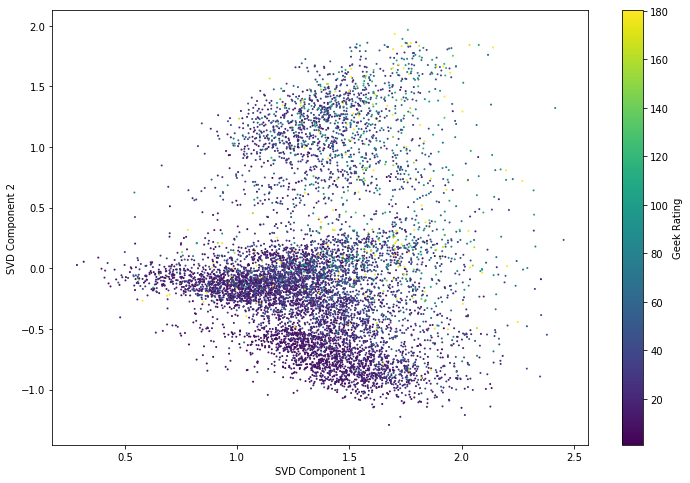

In [109]:
plt.figure(figsize=(12,8))
plt.scatter(X_2d[:,0],X_2d[:,1],c=y_train,s=1)
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
# plt.axhline(.2,alpha=.5,linestyle='--')
plt.colorbar(label='Geek Rating')
plt.savefig('plots/svd_price_all_2d.png')

In [ ]:
pd.read_csv

<IPython.core.display.Javascript object>


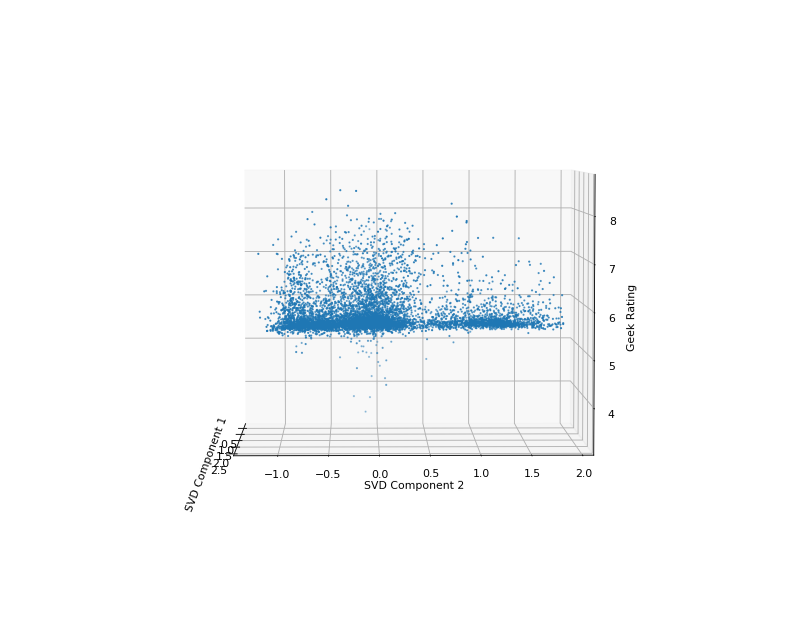

In [438]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_2d[:,0],X_2d[:,1],y_train,s=1)
ax.set_xlabel('SVD Component 1')
ax.set_ylabel('SVD Component 2')
ax.set_zlabel('Geek Rating')
plt.show()

In [440]:
columns = ['name_len','min_players','max_players','avg_time','year','age','weight','Classic'] +\
    fu.transformer_list[2][1].named_steps['countvectorizer'].get_feature_names()+\
    fu.transformer_list[3][1].named_steps['countvectorizer'].get_feature_names()+\
    fu.transformer_list[4][1].named_steps['countvectorizer'].get_feature_names()

In [441]:
len(columns)

388

In [442]:
svd.components_.shape

(2, 388)

In [443]:
foo = pd.DataFrame(svd.components_,columns=columns)

In [444]:
foo.loc[0,:][foo.loc[0,:]>=.1]

name_len                  0.235845
min_players               0.351207
max_players               0.255144
avg_time                  0.166097
year                      0.538880
age                       0.347389
weight                    0.235965
Dice Rolling              0.184506
Hand Management           0.165822
Variable Player Powers    0.104348
Card Game                 0.215026
Wargame                   0.154727
Name: 0, dtype: float64

In [446]:
market_df.category.str.contains('War').sum()

2695

In [447]:
foo.loc[1,:][foo.loc[1,:]>=.1]

avg_time           0.229115
weight             0.198291
Dice Rolling       0.249371
Hex-and-Counter    0.378520
Simulation         0.128595
Wargame            0.516804
World War II       0.202877
Name: 1, dtype: float64

In [448]:
y_train[X_2d[:,1] >= .5].mean()

5.698682538461538

In [449]:
y_train[X_2d[:,1] < .5].mean()

5.762382298165884

In [126]:
pd.DataFrame(y_train).to_csv('y.csv',index=False)

In [122]:
X_2d.shape

(3936, 2)

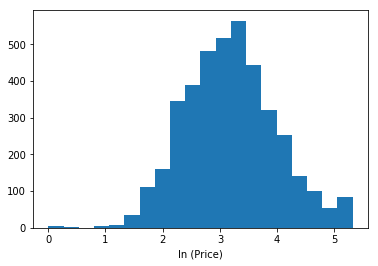

In [272]:
plt.hist(np.log(y_train),bins=20)
plt.xlabel('ln (Price)')
plt.savefig('market_logprice.png')

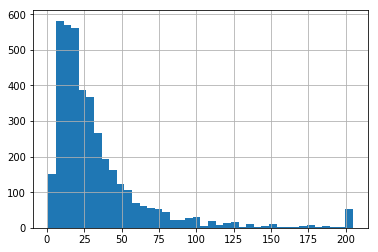

In [270]:
y_train.hist(bins=40)

In [164]:
new_df.shape

(49173, 24)

In [171]:
new_df.loc[new_df.avg_rating < new_df.geek_rating,'avg_rating'].max()

5.5002500000000003

In [172]:
new_df.loc[(new_df.avg_rating > new_df.geek_rating) & (new_df.geek_rating>0),'avg_rating'].min()

4.4068699999999996

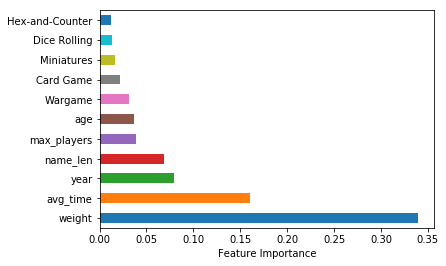

In [289]:
price_features = ['weight','avg_time','year','name_len','max_players','age','Wargame','Card Game',\
                 'Miniatures','Dice Rolling','Hex-and-Counter']
price_weights = [0.339946,0.160759,0.079557,0.068294,0.038685,0.036872,0.031744,0.022107,0.016085,0.013441,0.012306]
pd.Series(price_weights,price_features).plot.barh()
plt.xlabel('Feature Importance')
# plt.savefig('plots/price_feature_importances.png')

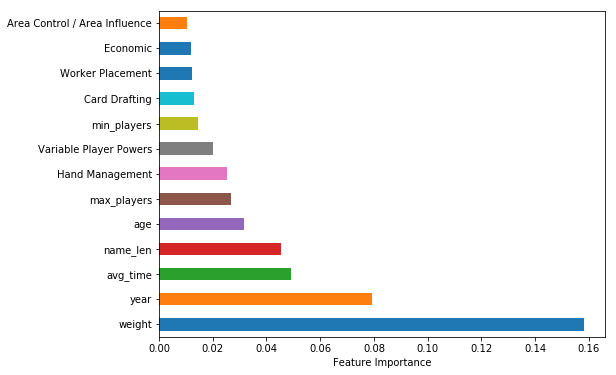

In [460]:
feature_importances.loc[feature_importances[0]>=0.01,0].plot.barh(figsize=(8,6))
plt.xlabel('Feature Importance')
plt.savefig('plots/rating_feature_importances.png')